In [1]:
from ensembles import VanillaEnsemble
from datasets import make_dataset, make_cross_validation_dataset
from plot import plot_dataset, plot_prediction, train_and_plot, plot_error
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 4]
from evaluation import evaluate_model
import tensorflow as tf

from tqdm import tqdm


# Explanation



Showing the efficiency of two estimators, comparing to a vanialla Neural Network.

All Estimators are built in tensorflow (1.4 [*]) and are based on the same parent object (ToDo: Make this more beautiful and readable). Code can be found in /estimators.

GaussianLossEstimator [1], in which $\mu$ and $\sigma^2$ are estimated directly by using a gaussian cost function $-1/2 ln [\sigma^2(x_i)] - \frac{[y-\hat{y}]^2}{2\sigma^2(x_i)} $. In practice, this means separate output nodes have been added for both mean and variance, with corrensponding final layers. To ensure positive $\sigma^2$, a softmax function is applied according to [2]. The derivatives used for the backwards pass update can be found in [1], thanks to Tensorflows Automatic Differentiation, the author was spared implementing a working function of this [4].

GaussianLearningRateEstimator, which is a GaussianLossEstimator in which the predicted $\sigma$ is used to scale the learning rate for each sample. This approach hasn't been found in a [arguable somewhat shallow] literature review. It's too early to claim novelty, but it is fun to work with!

For both models, a minimum variance is returned if the variance goes below a certain threshold to (try to) avoid numerical instabilities


No Regularisation has been added, thus quite a bit of overfitting occurs.







# Parameters
parameters have been chosen at 'random', i.e. not much thought has been put into them. No Gridsearch for optimal parameter spaces or similar.

each neural network is contains three hidden layers with 10 neurons each, the learning rate has been set to 0.001 which seems a literature standard (cite needed)

The layers are instantiated by draws from a normal distribution (0,1), so no distribution over parameters


# Dataset 
The Dataset contains 100 samples generated by the function 

$5 \cdot sin(X) + 10 + X^2 + noise$

where X is linearly spaced patches in the intervall [-5,5] the noise is drawn from a normal distribution (0,4)

# Training
Each network is trained on 10 * 100 = 1000 epochs

Training is on-line, i.e. each sample is fed into the network on a singular basis (Stochastic gradient descent with batch size 1)

The optimizer is the standard implementation of tensorflow's tf.train.GradientDescentOptimizer 


# Evaluation
Right now, the RSME and the coverage probability of the prediction is reported, where the data is available (i.e. VanillaNetwork does not return uncertainty = no Coverage). At the moment, evaluation happens on the training set (because the data generating model is a bit annoying to work with because of quite frankly a bit of a stupid shuffling situation, which is on the ToDo list)


# Problems/ToDo
Weirdly, the standard GaussianLossEstimator tends to fall into numerical instabilities (see e.g. seed #forgottowritedowntheseedandIfeelbad (1011???))

Overfitting is locally SEVERE sometimes (e.g. seed 43). Why.

Adding SOME Regularisation might be cool: The learning rate thing looks like a perfect fit for early stopping

Hyperparameters need to be tuned

Evaluation on training set (alas only to make a point about uncertainty so maybe can be forgiven in this phase)

Learningrate scaling in GaussianLearningRateEstimator is absolutely eyeballed and not based on any evidence at all except for the fact that 'I've seeb people use square roots in combination with the standard deviation/variance'.


Implement Dropout Estimator from [3] and give it the whole routine




# Sources

[1] Nix, D. A., & Weigend, A. S. (1994, June). Estimating the mean and variance of the target probability distribution. In Neural Networks, 1994. IEEE World Congress on Computational Intelligence., 1994 IEEE International Conference On (Vol. 1, pp. 55-60). IEEE.
Chicago	
Link: http://ieeexplore.ieee.org/abstract/document/374138/


[2] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. In Advances in Neural Information Processing Systems (pp. 6405-6416).
Chicago	

Link: https://arxiv.org/abs/1612.01474

[3] Gal, Y., & Ghahramani, Z. (2016, June). Dropout as a Bayesian approximation: Representing model uncertainty in deep learning. In international conference on machine learning (pp. 1050-1059).

Link: http://proceedings.mlr.press/v48/gal16.html

[4] Huxley, Aldous. Brave New World. New York: Harper Brothers, 1932. Print. 


[*] BIG shoutout to https://danijar.com/structuring-your-tensorflow-models/ for helping me understand how to use Tensorflow in an object oriented manner


# Preparations

In [2]:
num_epochs = 10
num_eps = 25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}
          #'optimizer':tf.train.AdamOptimizer}


In [3]:

data = make_dataset(train_p=0.8,seed=seed)

X = data['X']
y = data['y']
X_test = data['X_test']
y_test = data['y_test']
generate_sinoid = data['generating']
#sorted_index = data['train_index']
sorted_index = data['shuffle_index']
#test_index = data['test_ind']

In [4]:
#X_test[:10],X[:10]

In [5]:
#len(X), len(sorted_index),len(data['test_ind']),len(X_test)

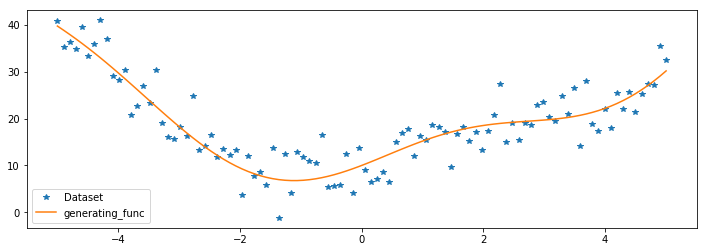

In [6]:
plot_dataset(X,y,sorted_index,generating_func=generate_sinoid)

# initialise Networks

In [7]:
from estimators import GaussianLossEstimator,GaussianLearningRateEstimator, EnsembleNetwork

gauss = GaussianLossEstimator(**params)
gauss_lr = GaussianLearningRateEstimator(**params)
vanilla = EnsembleNetwork(**params)

In [8]:
gauss_preds = gauss.predict(X)
gauss_var = gauss.predict_var(X)


lr_preds = gauss_lr.predict(X)
lr_var = gauss_lr.predict_var(X)

vanilla_preds = vanilla.predict(X)

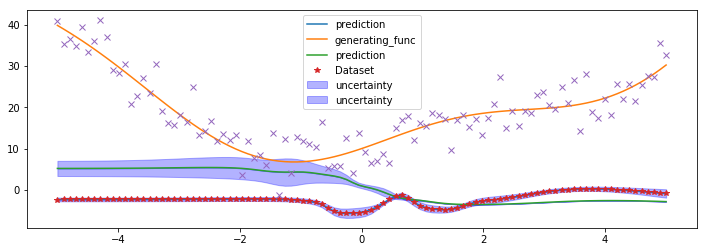

In [9]:
plot_prediction(X,
                gauss_preds,
                sorted_index,
                gauss_var,
                generating_func=generate_sinoid)
plot_prediction(X,
                lr_preds,
                sorted_index,
                lr_var)
plot_prediction(X,vanilla_preds,sorted_index)
plt.plot(X,y,'x')

In [10]:
evaluate_model(X,y,gauss_preds)

RSME is 22.714372634887695


In [11]:
evaluate_model(X,y,lr_preds)

RSME is 20.267982482910156


In [12]:
evaluate_model(X,y,vanilla_preds)

RSME is 22.714372634887695


# Training


## GaussianLossEstimator

Maye replace min_variance with 

In [13]:
num_eps

25

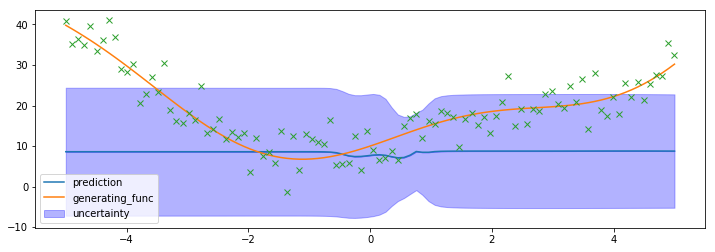

RSME is 13.596102714538574
COVERAGE PROBABILITY is 0.72
MEAN VARIANCE is 14.639887809753418
COVERAGE/MEAN_VAR is 0.0491807047537837


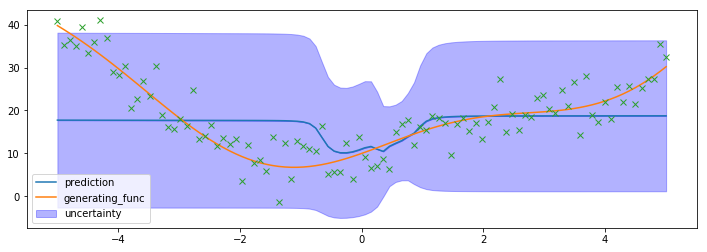

RSME is 8.456581115722656
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 18.001354217529297
COVERAGE/MEAN_VAR is 0.05388483490066746


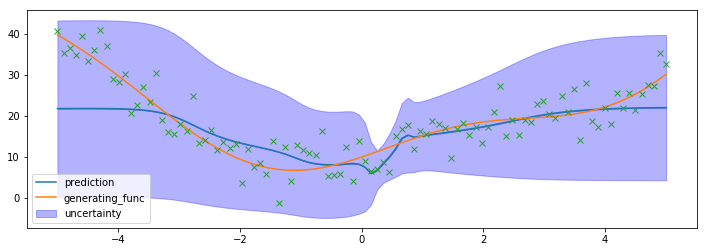

RSME is 6.315575122833252
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 15.446916580200195
COVERAGE/MEAN_VAR is 0.06473783908963401


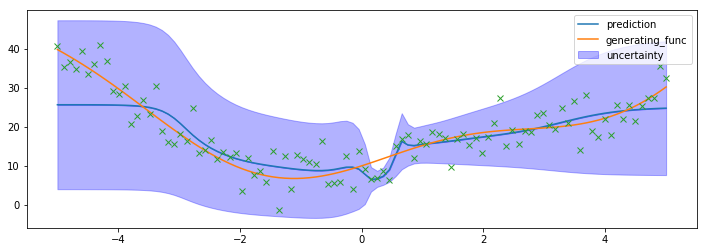

RSME is 5.198561191558838
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 13.319430351257324
COVERAGE/MEAN_VAR is 0.07357672018664749


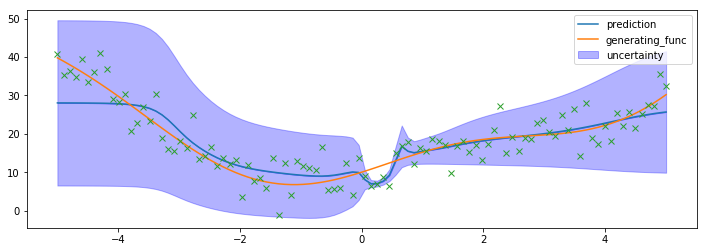

RSME is 4.714400291442871
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 11.75202751159668
COVERAGE/MEAN_VAR is 0.08083711504781263


In [14]:
errors = train_and_plot(gauss,X,y,sorted_index,generating_func=generate_sinoid,
               num_eps=num_eps)

In [16]:
#plot_error(errors)

gauss_error_list = []
#for i in tqdm(range(num_eps)):
for i in range(num_eps):
    #gauss.train(X,y)
    errors = gauss.train_and_evaluate(X,y)
    gauss_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        gauss_preds = gauss.predict(X)
        gauss_var = gauss.predict_var(X)

        #lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds,var=gauss_var)
#plt.show()

## GaussianLearningRateEstimator

gauss_lr_error_list = []
for i in range(num_eps):
    errors = gauss_lr.train_and_evaluate(X,y)
    gauss_lr_error_list += errors
    #gauss_lr.train(X,y)
    #vanilla.train(X,y)
    if i%(num_eps/5) ==0:
        gauss_preds = gauss_lr.predict(X)
        gauss_var = gauss_lr.predict_var(X)

        #3lr_preds = gauss_lr.predict(X)
        #lr_var = gauss_lr.predict_var(X)

        #vanilla_preds = vanilla.predict(X)
        plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,gauss_preds,var=gauss_var)

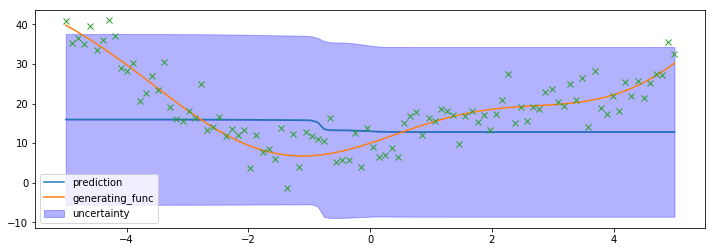

RSME is 10.119905471801758
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 21.49254608154297
COVERAGE/MEAN_VAR is 0.0446666484444304


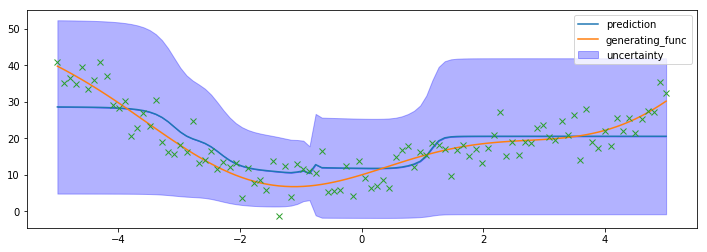

RSME is 5.427537441253662
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 18.100099563598633
COVERAGE/MEAN_VAR is 0.05469583172851729


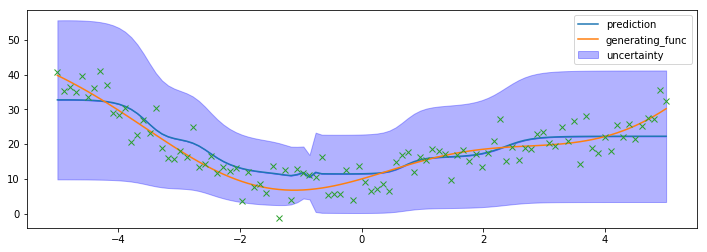

RSME is 4.612155914306641
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 15.463481903076172
COVERAGE/MEAN_VAR is 0.06402180351134616


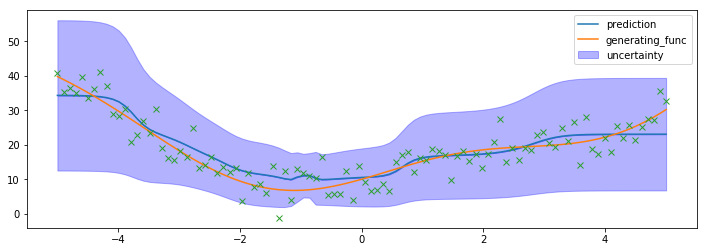

RSME is 4.283489227294922
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 13.345697402954102
COVERAGE/MEAN_VAR is 0.07418121137535016


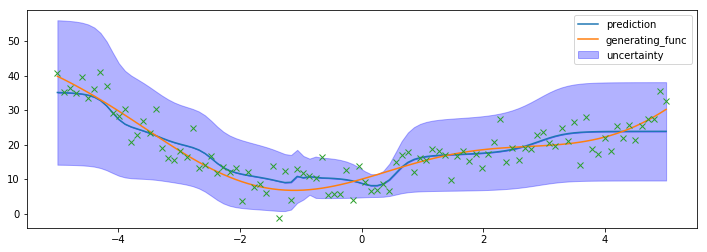

RSME is 4.033595085144043
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 11.502309799194336
COVERAGE/MEAN_VAR is 0.08346149745221103


In [17]:
errors = train_and_plot(gauss_lr,X,y,sorted_index,generating_func=generate_sinoid,
               num_eps=num_eps)

In [19]:
#plot_error(errors)

## Vanilla Neural Network for comparisson

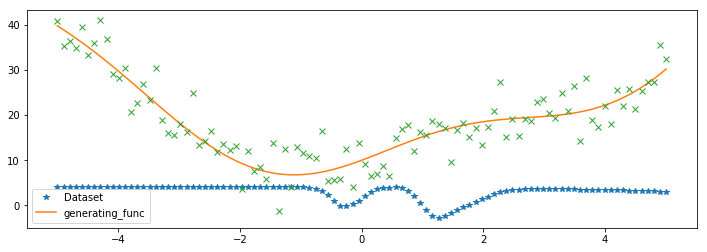

RSME is 18.102985382080078


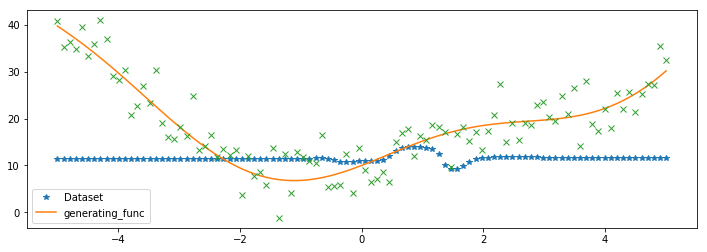

RSME is 11.605433464050293


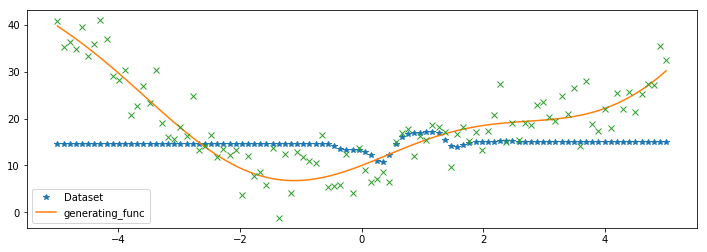

RSME is 9.77886962890625


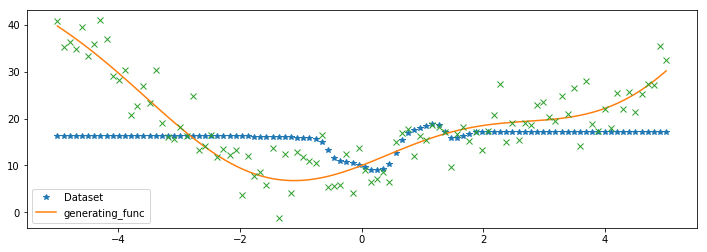

RSME is 8.8622407913208


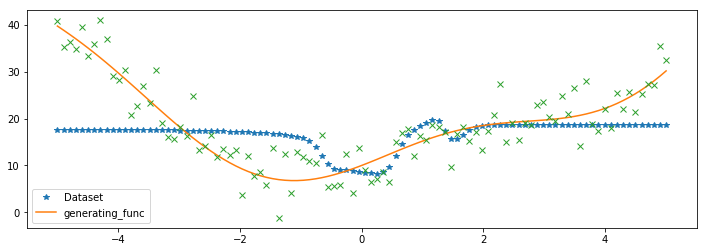

RSME is 8.30289077758789


In [20]:
vanilla_errors = []
for i in range(num_eps):

    vanilla.train(X,y)
    if i%(num_eps/5) ==0:


        vanilla_preds = vanilla.predict(X)
        plot_prediction(X,vanilla_preds,sorted_index,generating_func=generate_sinoid)
        plt.plot(X,y,'x')
        plt.show()
        evaluate_model(X,y,vanilla_preds)

# loop over experiment forever

In [21]:

def plot_error_tmp(error_list, variance_list=False):
    if len(variance_list) > 0:
        diff = error_list - variance_list
        sum_ = error_list + variance_list
        X = np.linspace(0, len(error_list), len(error_list))
        plt.plot()
        plt.xlim = 50
        plt.fill_between(X, error_list, diff, alpha=.3,
                         color='b')
        plt.fill_between(X, error_list, sum_, alpha=.3,
                         color='b')
        #plt.plot(X,error_list)
        plt.xlim = 50
        plt.show()

        
    else:
        plt.plot(np.squeeze(error_list))
        
        
def plottt(error_list):
    plt.plot(np.squeeze(error_list))

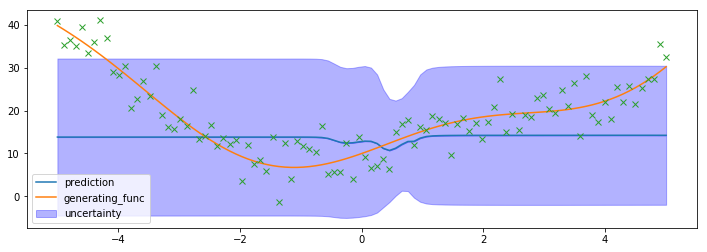

RSME is 10.195372581481934
COVERAGE PROBABILITY is 0.89
MEAN VARIANCE is 16.953123092651367
COVERAGE/MEAN_VAR is 0.05249770175890402


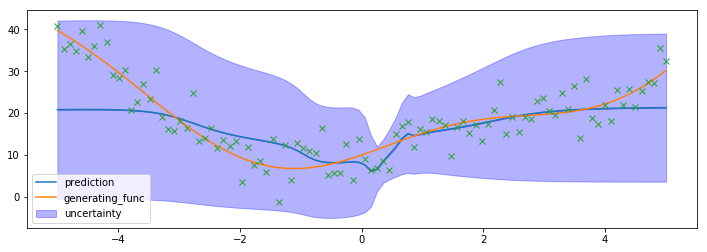

RSME is 6.718274116516113
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 15.927692413330078
COVERAGE/MEAN_VAR is 0.06278373376692584


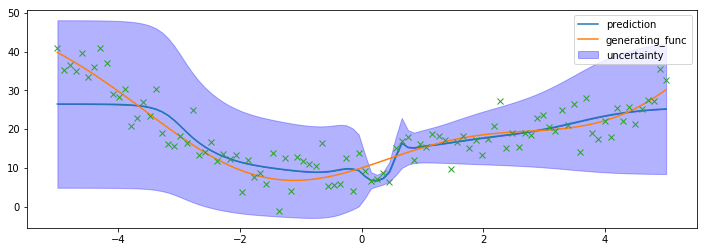

RSME is 5.019496440887451
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.774383544921875
COVERAGE/MEAN_VAR is 0.075933214044258


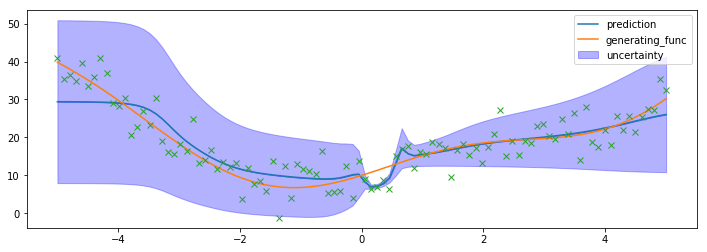

RSME is 4.490230083465576
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 11.162134170532227
COVERAGE/MEAN_VAR is 0.08421328624427199


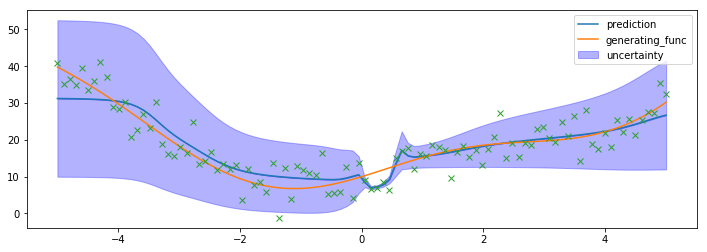

RSME is 4.2063093185424805
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 10.566790580749512
COVERAGE/MEAN_VAR is 0.08801158619479656


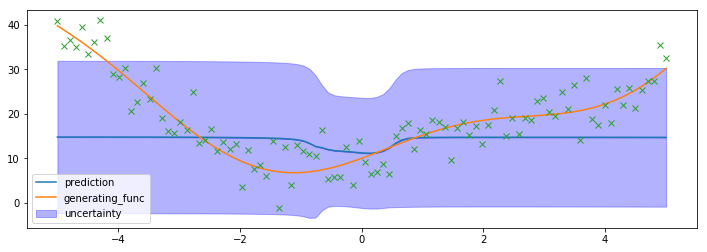

RSME is 9.748335838317871
COVERAGE PROBABILITY is 0.89
MEAN VARIANCE is 15.85536003112793
COVERAGE/MEAN_VAR is 0.05613243712238091


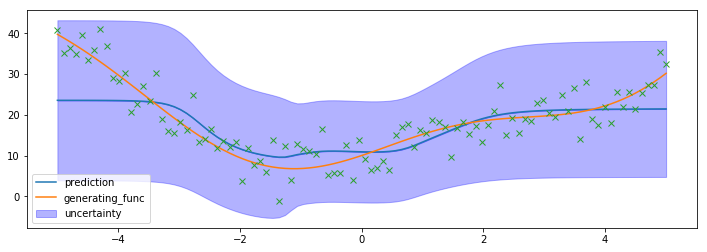

RSME is 5.9724040031433105
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 15.961993217468262
COVERAGE/MEAN_VAR is 0.06264881749890948


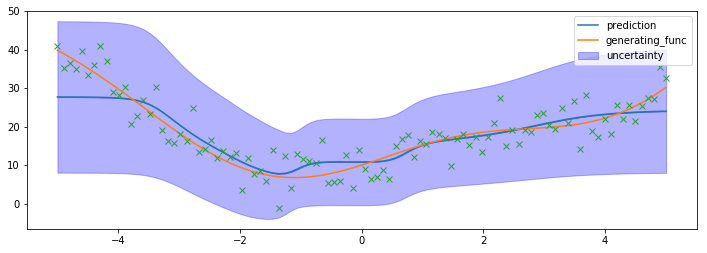

RSME is 4.873468399047852
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 14.345921516418457
COVERAGE/MEAN_VAR is 0.06970622269580462


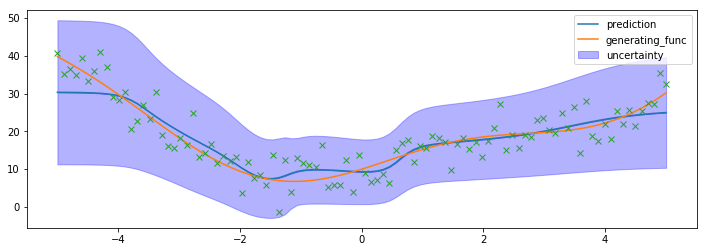

RSME is 4.345925807952881
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 12.48058795928955
COVERAGE/MEAN_VAR is 0.08012443029622494


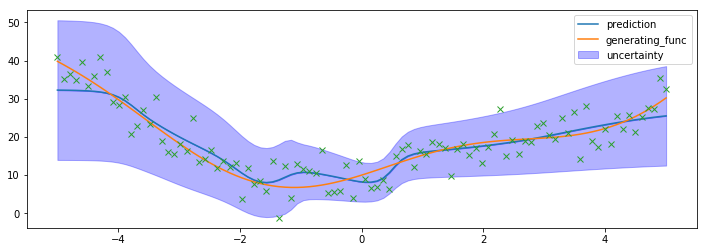

RSME is 4.072149753570557
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.388949394226074
COVERAGE/MEAN_VAR is 0.09336844017539468


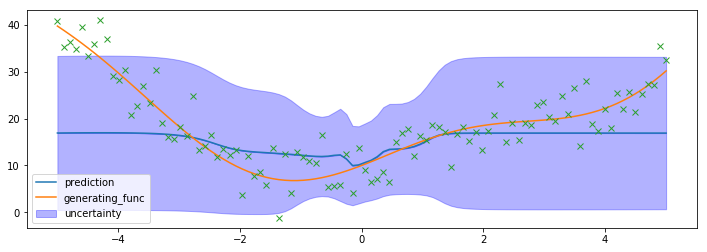

RSME is 8.480454444885254
COVERAGE PROBABILITY is 0.9
MEAN VARIANCE is 14.285266876220703
COVERAGE/MEAN_VAR is 0.06300197313766273


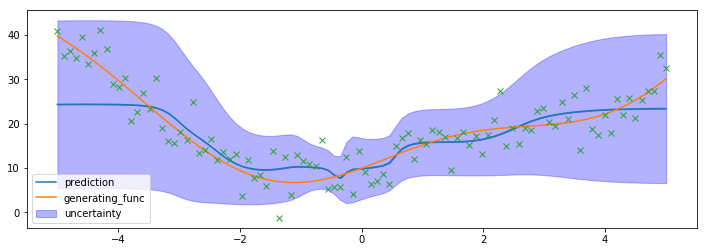

RSME is 5.505842685699463
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.021754264831543
COVERAGE/MEAN_VAR is 0.08068705936184699


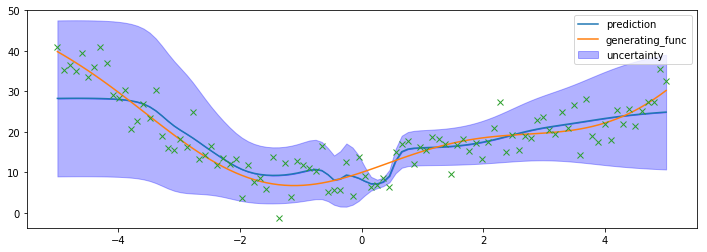

RSME is 4.61195182800293
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.999556541442871
COVERAGE/MEAN_VAR is 0.09600425739094608


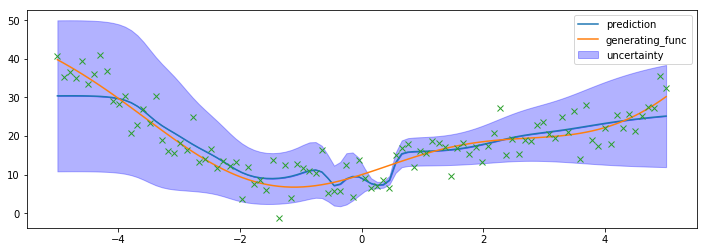

RSME is 4.225605010986328
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 9.471189498901367
COVERAGE/MEAN_VAR is 0.099248357358813


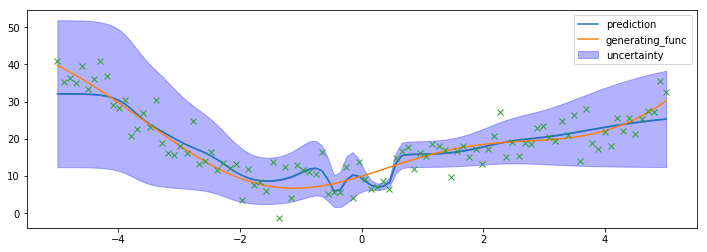

RSME is 3.9604058265686035
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 9.205617904663086
COVERAGE/MEAN_VAR is 0.10102526627016646


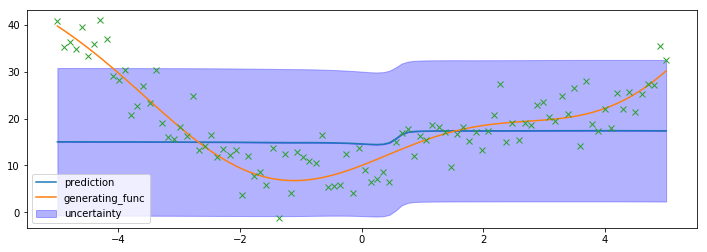

RSME is 9.352471351623535
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 15.438794136047363
COVERAGE/MEAN_VAR is 0.05699927029568499


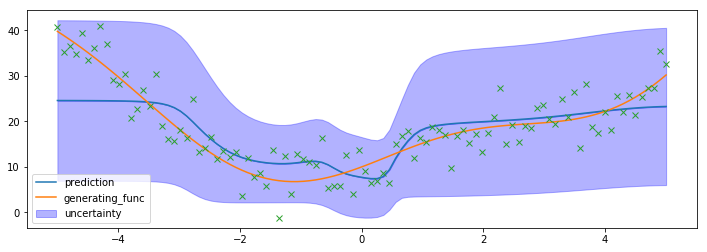

RSME is 5.666406631469727
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 14.319710731506348
COVERAGE/MEAN_VAR is 0.06913547477057576


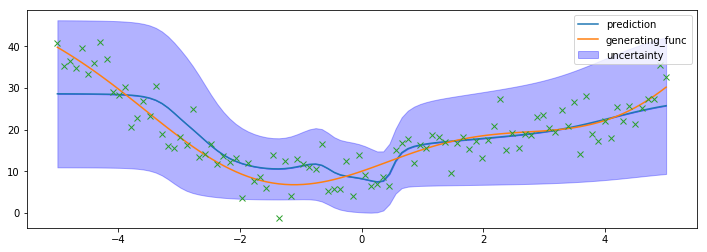

RSME is 4.780282497406006
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 12.374595642089844
COVERAGE/MEAN_VAR is 0.08000261411635161


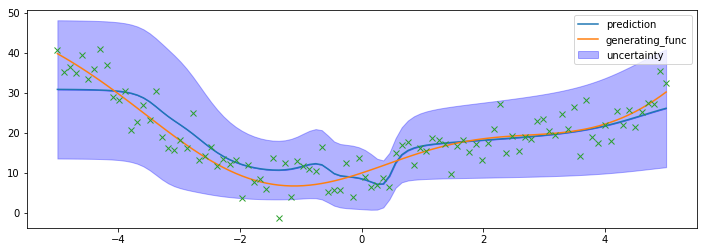

RSME is 4.465020179748535
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 11.235668182373047
COVERAGE/MEAN_VAR is 0.0872222269377323


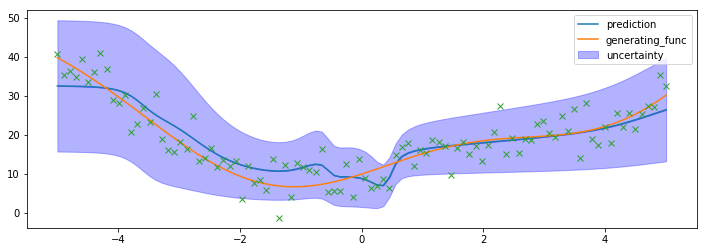

RSME is 4.210024833679199
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.307541847229004
COVERAGE/MEAN_VAR is 0.09313568785151996


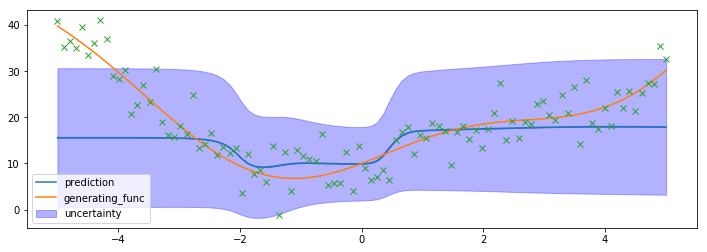

RSME is 8.598617553710938
COVERAGE PROBABILITY is 0.89
MEAN VARIANCE is 13.027894020080566
COVERAGE/MEAN_VAR is 0.06831495548153807


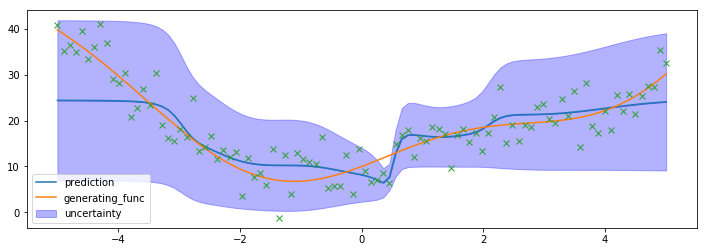

RSME is 5.47857141494751
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 11.564908027648926
COVERAGE/MEAN_VAR is 0.08473910883312298


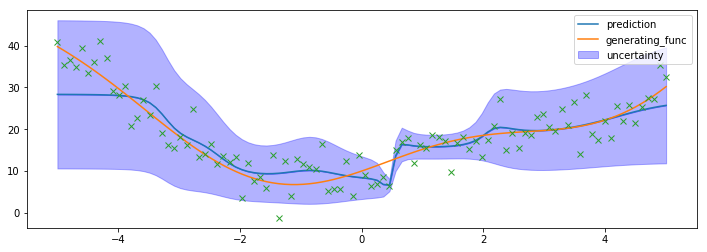

RSME is 4.543712615966797
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.75898265838623
COVERAGE/MEAN_VAR is 0.0973462125361635


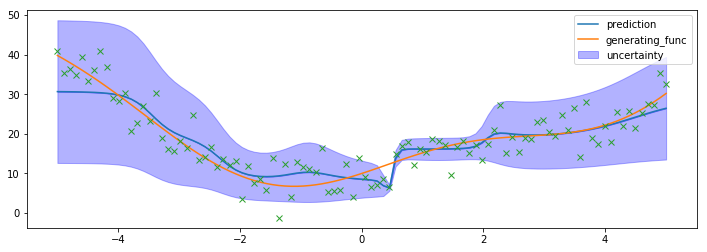

RSME is 4.162479877471924
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 9.046813011169434
COVERAGE/MEAN_VAR is 0.10390399346592565


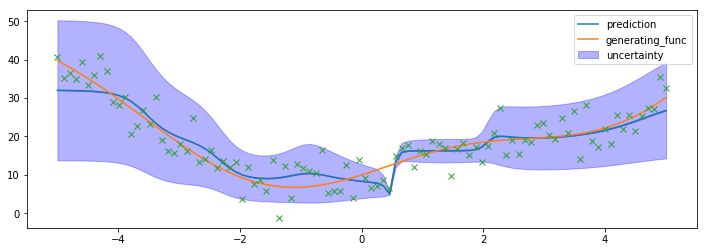

RSME is 3.9899470806121826
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 8.851219177246094
COVERAGE/MEAN_VAR is 0.10394048340425825


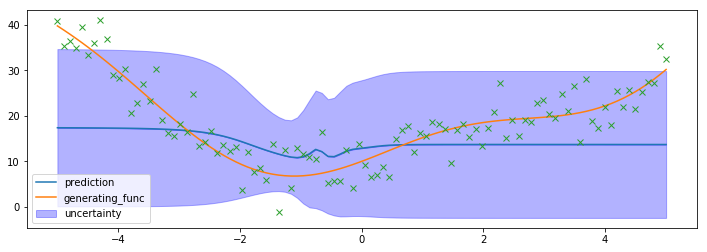

RSME is 9.200813293457031
COVERAGE PROBABILITY is 0.89
MEAN VARIANCE is 15.257682800292969
COVERAGE/MEAN_VAR is 0.05833126901700374


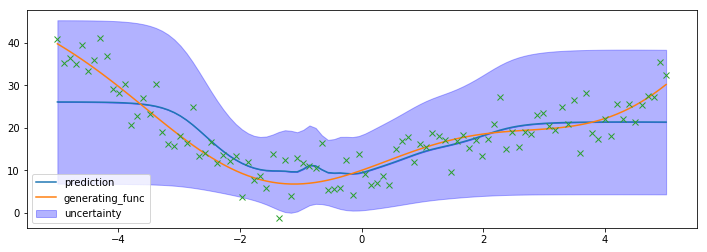

RSME is 5.439298152923584
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 14.015863418579102
COVERAGE/MEAN_VAR is 0.06992077267968629


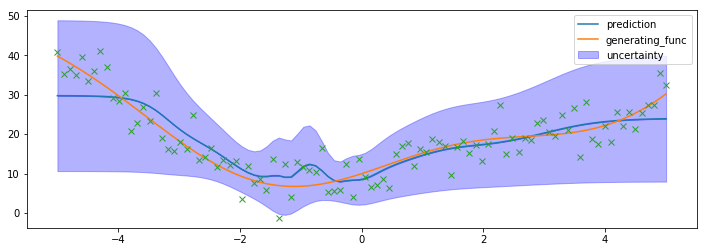

RSME is 4.582767009735107
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 11.905176162719727
COVERAGE/MEAN_VAR is 0.0823171355556086


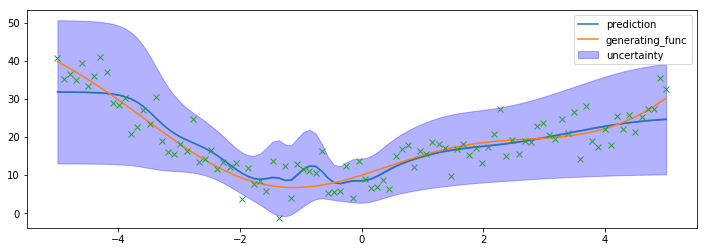

RSME is 4.2298808097839355
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 10.732304573059082
COVERAGE/MEAN_VAR is 0.09131309993382583


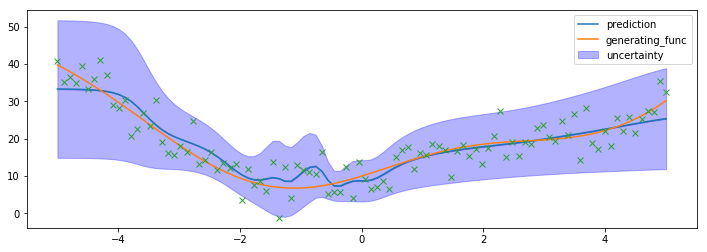

RSME is 4.020761013031006
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 9.999978065490723
COVERAGE/MEAN_VAR is 0.09700021276520668


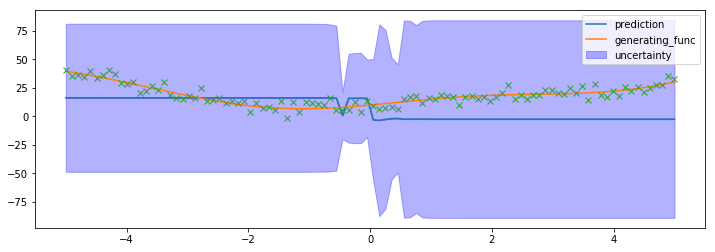

RSME is 17.6196231842041
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 73.07750701904297
COVERAGE/MEAN_VAR is 0.013684101179579293


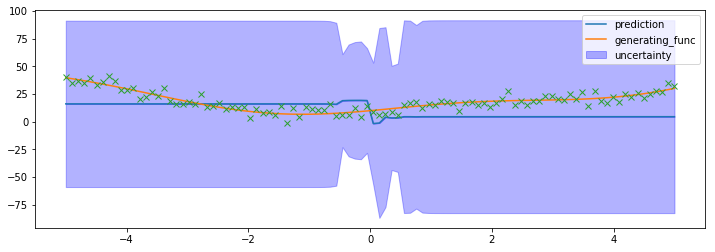

RSME is 13.927238464355469
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 78.66226959228516
COVERAGE/MEAN_VAR is 0.01271257497632735


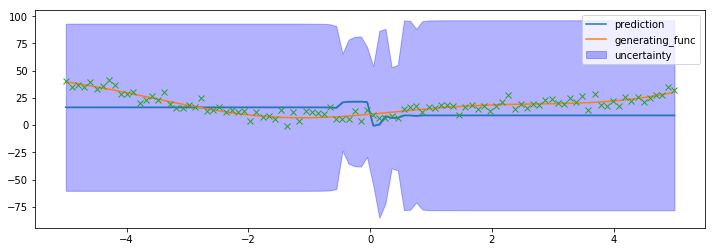

RSME is 11.863138198852539
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 79.55239868164062
COVERAGE/MEAN_VAR is 0.01257033121027416


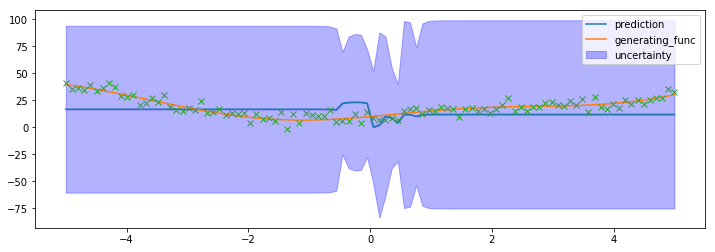

RSME is 10.754928588867188
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 79.39852142333984
COVERAGE/MEAN_VAR is 0.012594692975051319


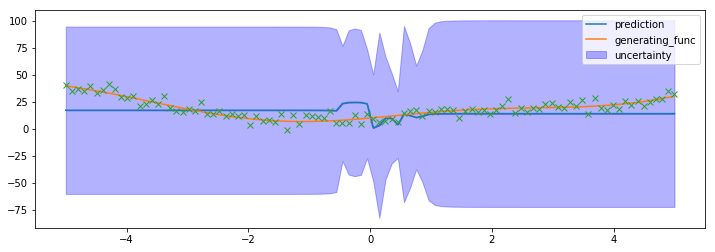

RSME is 10.166775703430176
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 78.43600463867188
COVERAGE/MEAN_VAR is 0.012749247040395052


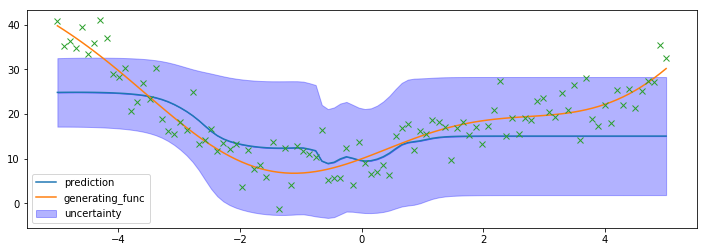

RSME is 6.990441799163818
COVERAGE PROBABILITY is 0.89
MEAN VARIANCE is 12.220174789428711
COVERAGE/MEAN_VAR is 0.07283038216195656


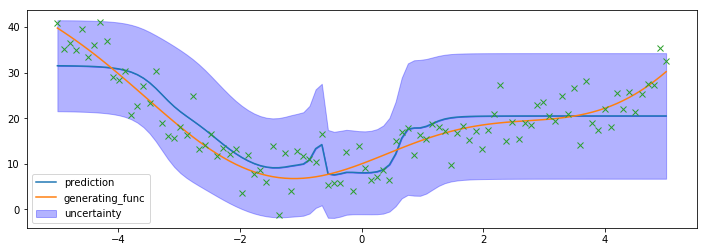

RSME is 4.794007778167725
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 12.281235694885254
COVERAGE/MEAN_VAR is 0.08061078091777879


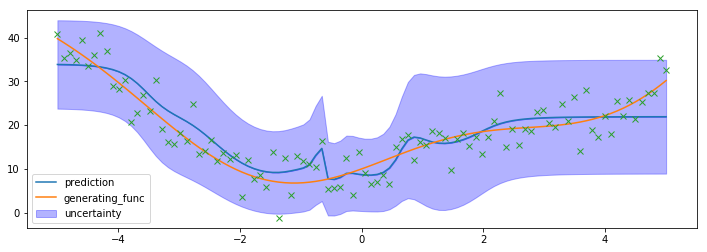

RSME is 4.3033857345581055
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 11.799284934997559
COVERAGE/MEAN_VAR is 0.08305588053842541


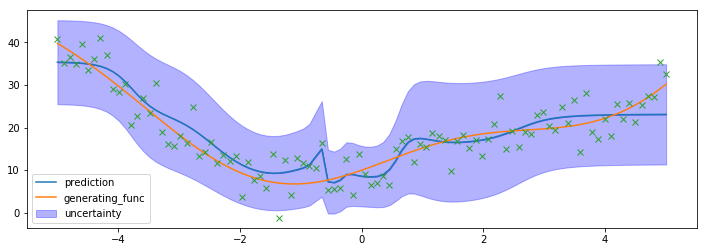

RSME is 4.025902271270752
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 10.990825653076172
COVERAGE/MEAN_VAR is 0.08916527574302048


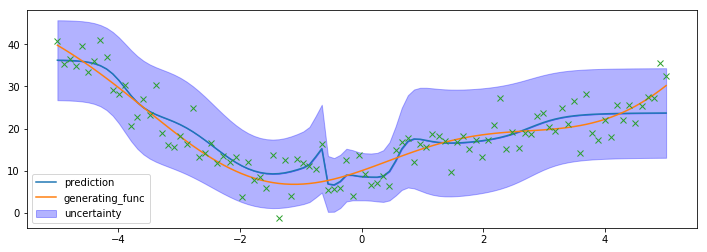

RSME is 3.889948606491089
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 10.073251724243164
COVERAGE/MEAN_VAR is 0.09728735336191854


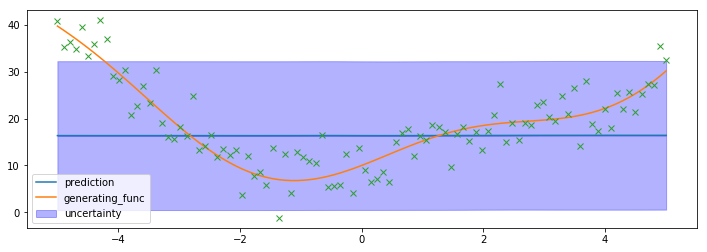

RSME is 9.410113334655762
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 15.896932601928711
COVERAGE/MEAN_VAR is 0.05535659123906917


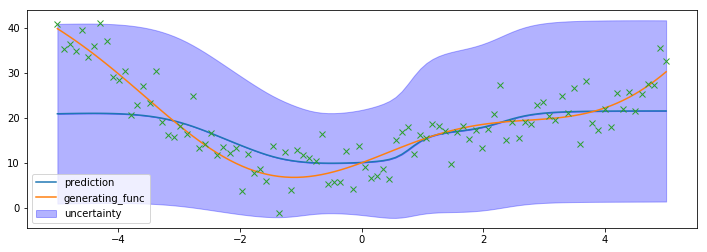

RSME is 6.650126934051514
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 17.24706268310547
COVERAGE/MEAN_VAR is 0.05740107855987352


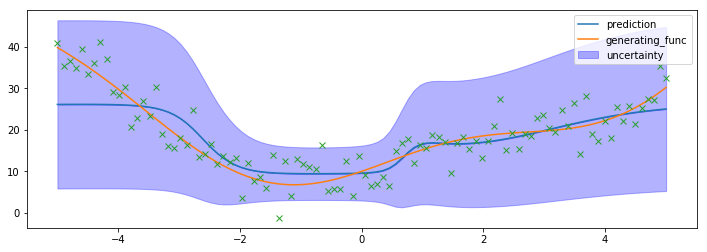

RSME is 5.187772750854492
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 14.617300033569336
COVERAGE/MEAN_VAR is 0.06704384515261934


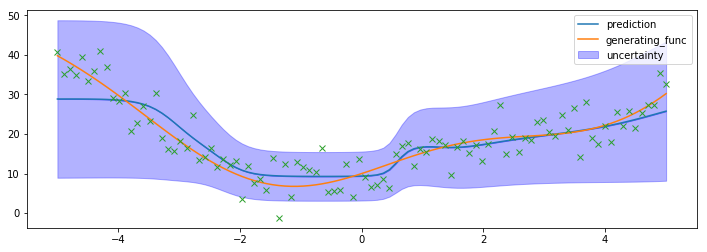

RSME is 4.640017509460449
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 11.784891128540039
COVERAGE/MEAN_VAR is 0.08230877904768286


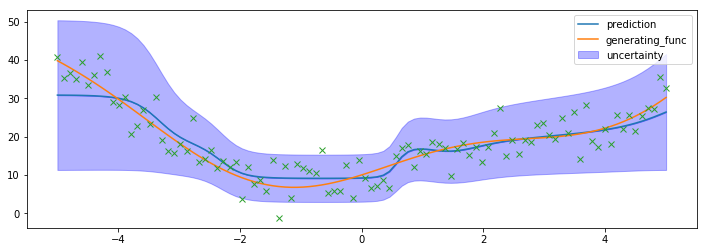

RSME is 4.247673511505127
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.312243461608887
COVERAGE/MEAN_VAR is 0.09406294601278385


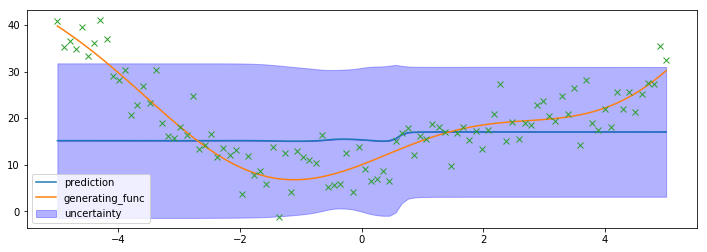

RSME is 9.440644264221191
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 15.23914909362793
COVERAGE/MEAN_VAR is 0.05774600632839544


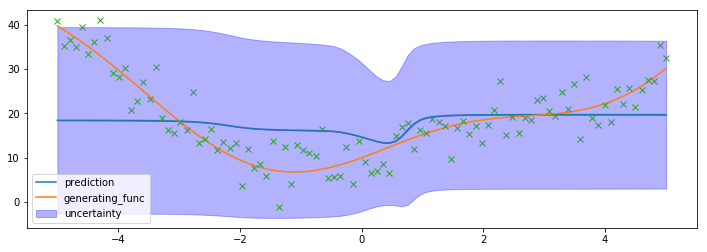

RSME is 8.301167488098145
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 18.417390823364258
COVERAGE/MEAN_VAR is 0.05266761232918293


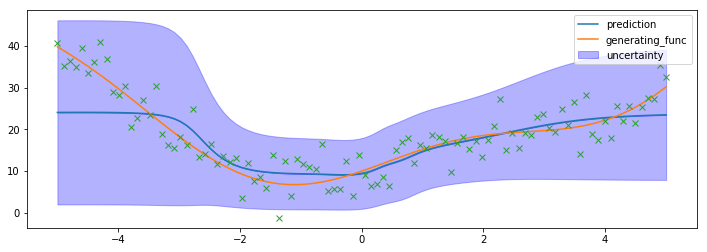

RSME is 5.657619476318359
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 13.553570747375488
COVERAGE/MEAN_VAR is 0.07304348193199961


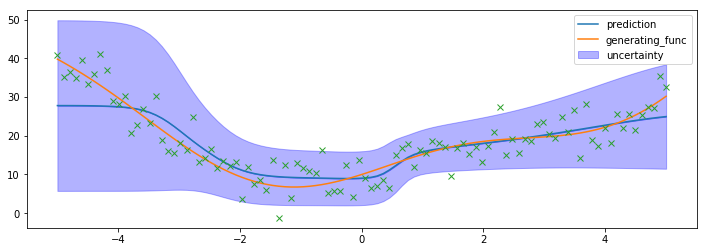

RSME is 4.815589904785156
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.984432220458984
COVERAGE/MEAN_VAR is 0.08739641528416535


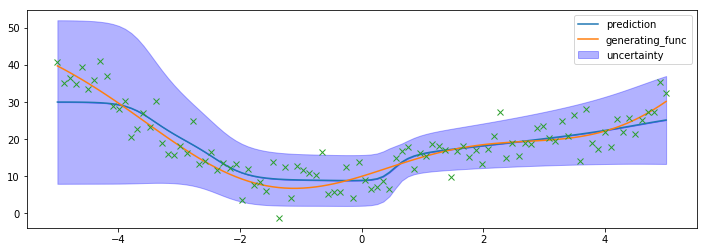

RSME is 4.415229320526123
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.050216674804688
COVERAGE/MEAN_VAR is 0.09552032867178521


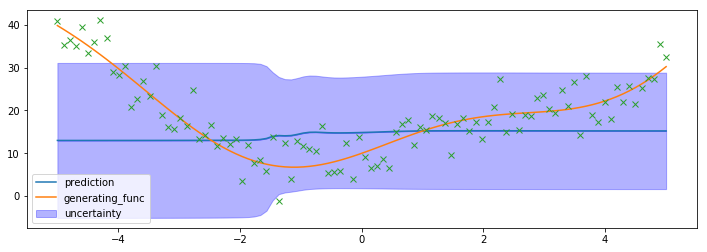

RSME is 10.362749099731445
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 15.053265571594238
COVERAGE/MEAN_VAR is 0.05845907625921213


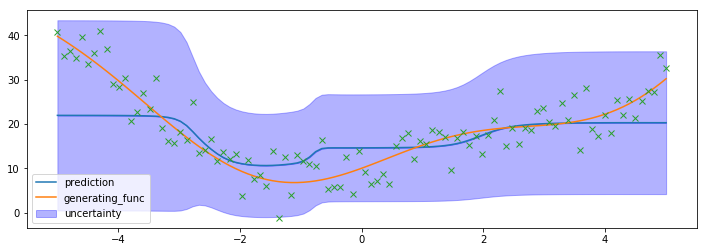

RSME is 6.704611778259277
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 15.378498077392578
COVERAGE/MEAN_VAR is 0.06437559734492969


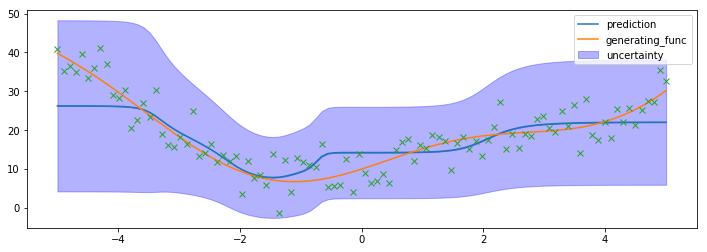

RSME is 5.4962639808654785
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 14.866230010986328
COVERAGE/MEAN_VAR is 0.06726654970769237


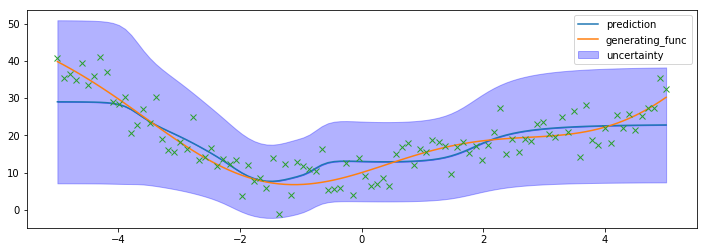

RSME is 4.899421215057373
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 13.985923767089844
COVERAGE/MEAN_VAR is 0.07150046122467014


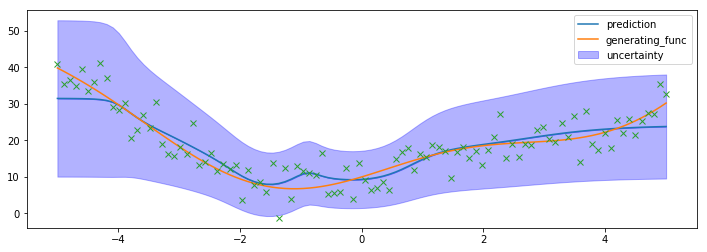

RSME is 4.275816917419434
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 12.555276870727539
COVERAGE/MEAN_VAR is 0.07885130771653247


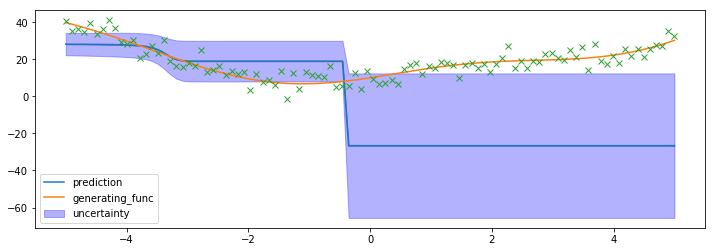

RSME is 33.7979621887207
COVERAGE PROBABILITY is 0.4
MEAN VARIANCE is 25.335710525512695
COVERAGE/MEAN_VAR is 0.015787992193753785


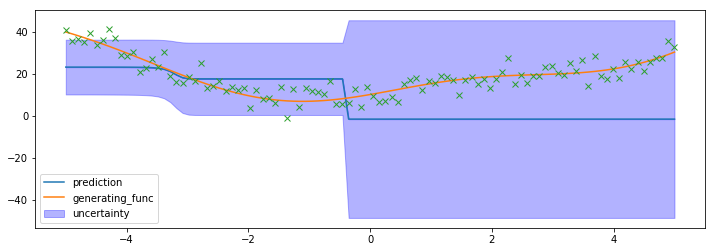

RSME is 16.630657196044922
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 32.60286331176758
COVERAGE/MEAN_VAR is 0.028831823481611788


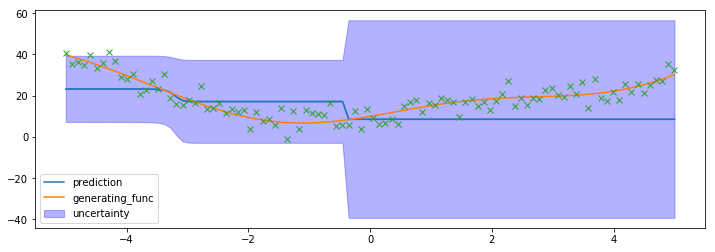

RSME is 10.487058639526367
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 34.385986328125
COVERAGE/MEAN_VAR is 0.02820916610458305


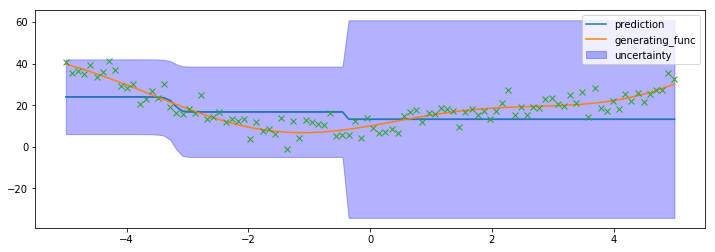

RSME is 8.38850212097168
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 35.02399826049805
COVERAGE/MEAN_VAR is 0.028551851577946596


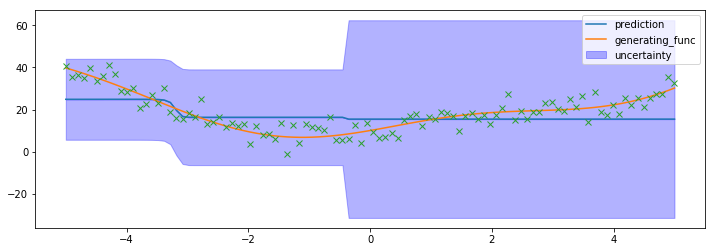

RSME is 7.613518714904785
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 35.241004943847656
COVERAGE/MEAN_VAR is 0.028376035291654732


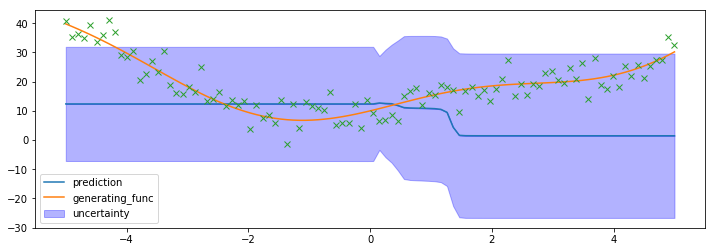

RSME is 15.44770622253418
COVERAGE PROBABILITY is 0.89
MEAN VARIANCE is 23.1281795501709
COVERAGE/MEAN_VAR is 0.038481195550621


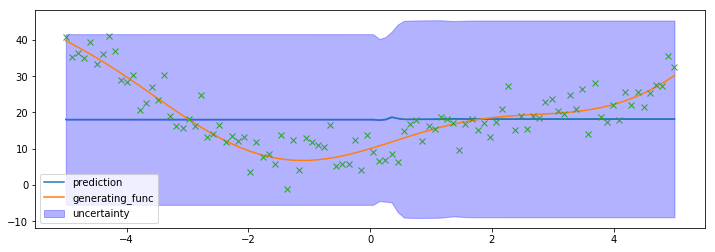

RSME is 9.134621620178223
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 25.174942016601562
COVERAGE/MEAN_VAR is 0.039722037863704


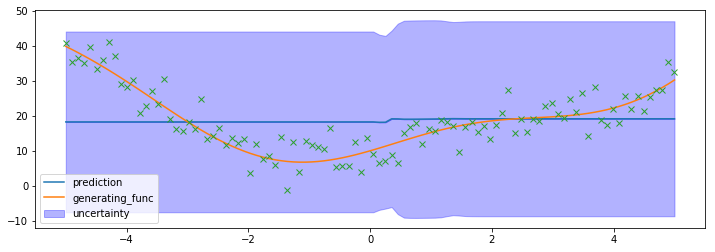

RSME is 9.077848434448242
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 26.708860397338867
COVERAGE/MEAN_VAR is 0.03744075880151123


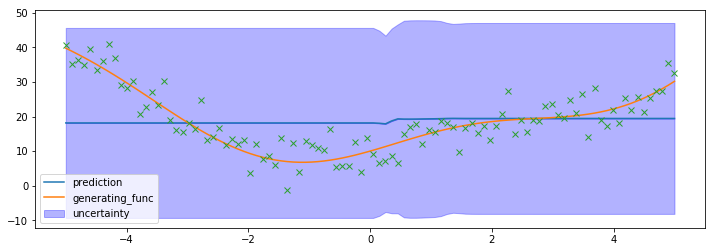

RSME is 9.05742073059082
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 27.578393936157227
COVERAGE/MEAN_VAR is 0.0362602696268302


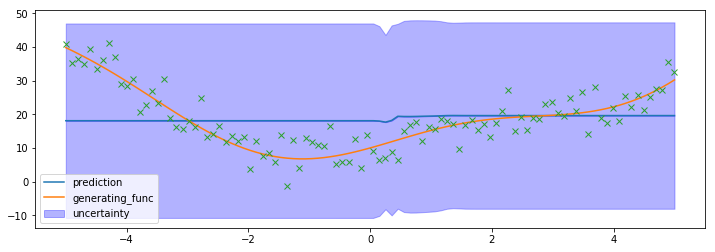

RSME is 9.041970252990723
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 28.3211612701416
COVERAGE/MEAN_VAR is 0.03530928659533035


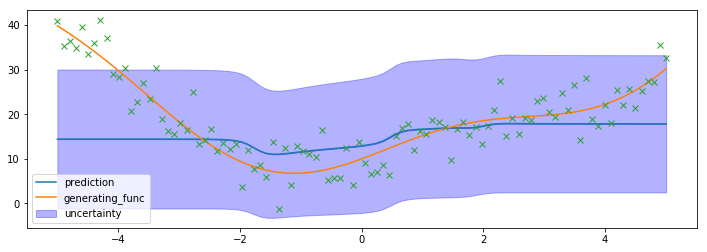

RSME is 9.179665565490723
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 15.275425910949707
COVERAGE/MEAN_VAR is 0.05760886833074813


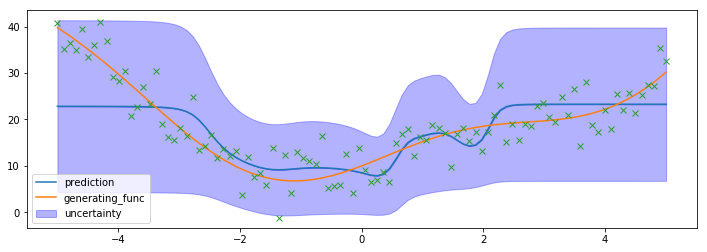

RSME is 6.022951126098633
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 14.08531379699707
COVERAGE/MEAN_VAR is 0.07028597404844923


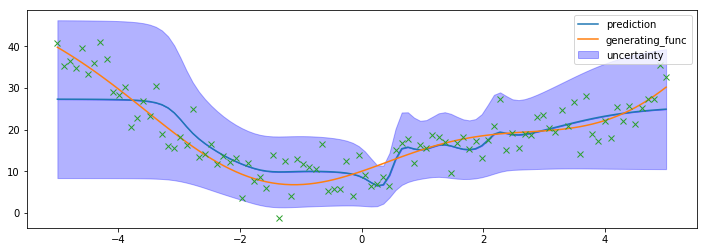

RSME is 4.936038970947266
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 11.236989974975586
COVERAGE/MEAN_VAR is 0.08810188513157866


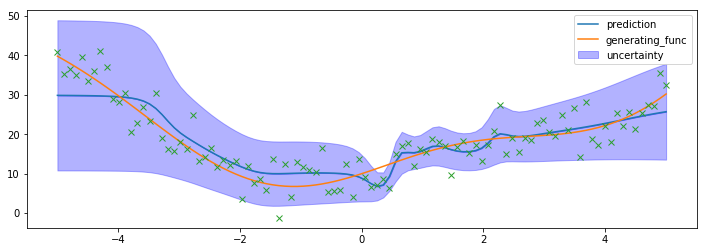

RSME is 4.418819904327393
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 9.581880569458008
COVERAGE/MEAN_VAR is 0.1022763739222261


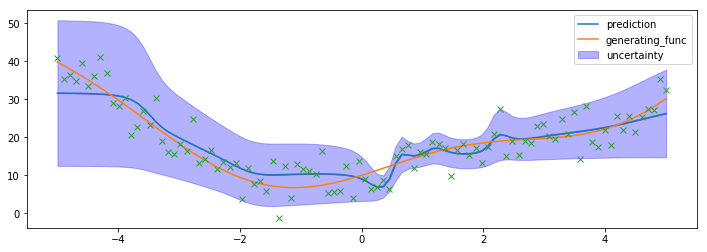

RSME is 4.124098300933838
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 8.972240447998047
COVERAGE/MEAN_VAR is 0.10811123549597175


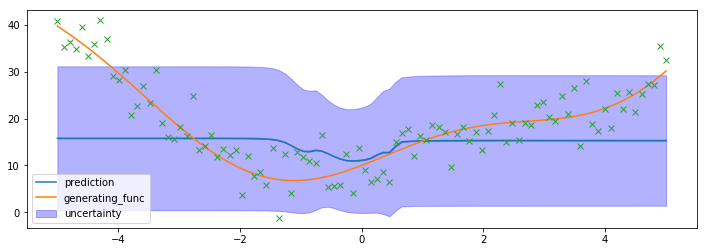

RSME is 9.353156089782715
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 14.178488731384277
COVERAGE/MEAN_VAR is 0.06206585318589759


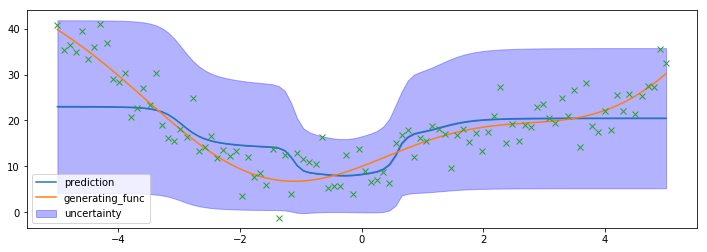

RSME is 6.384693145751953
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 14.431419372558594
COVERAGE/MEAN_VAR is 0.06860032090000026


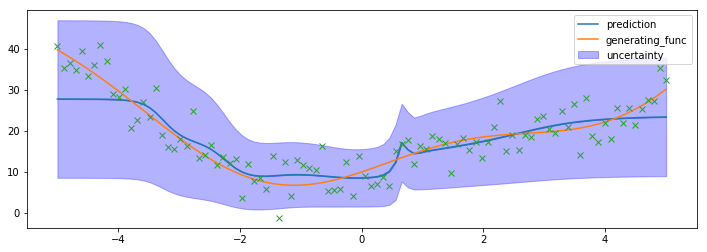

RSME is 4.7545576095581055
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 12.316883087158203
COVERAGE/MEAN_VAR is 0.08037747805142287


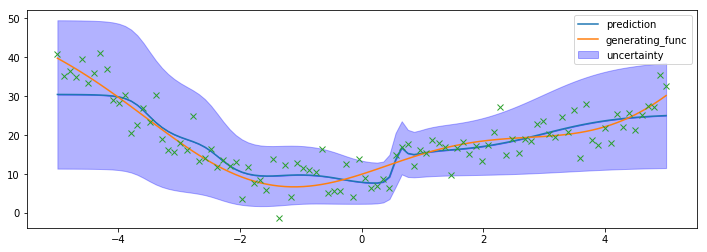

RSME is 4.295447826385498
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.782588958740234
COVERAGE/MEAN_VAR is 0.08995984208539544


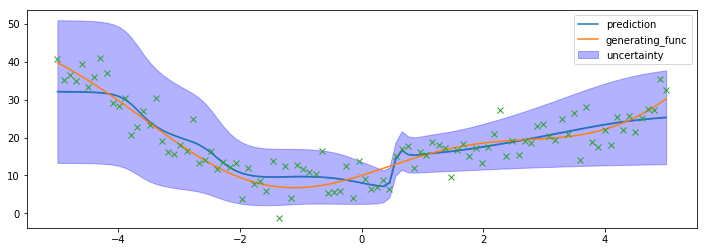

RSME is 4.0883259773254395
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 9.894721984863281
COVERAGE/MEAN_VAR is 0.09803206209167713


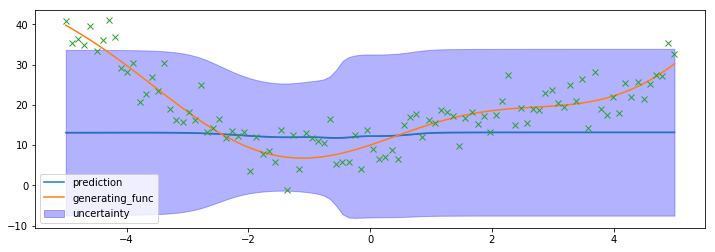

RSME is 10.61242961883545
COVERAGE PROBABILITY is 0.91
MEAN VARIANCE is 19.226192474365234
COVERAGE/MEAN_VAR is 0.047331264430714816


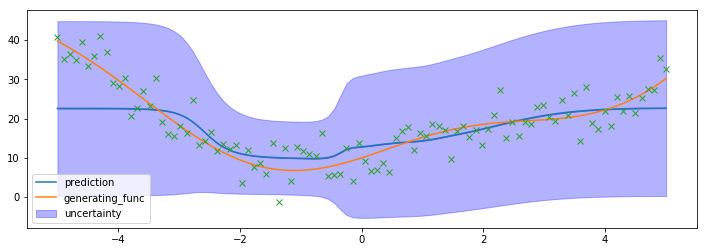

RSME is 6.154746055603027
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 18.490550994873047
COVERAGE/MEAN_VAR is 0.0535408598842999


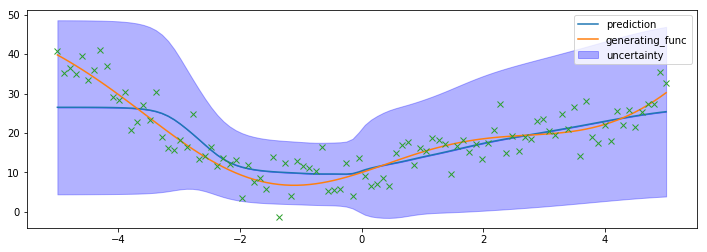

RSME is 5.1523237228393555
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 15.872184753417969
COVERAGE/MEAN_VAR is 0.062373265897551385


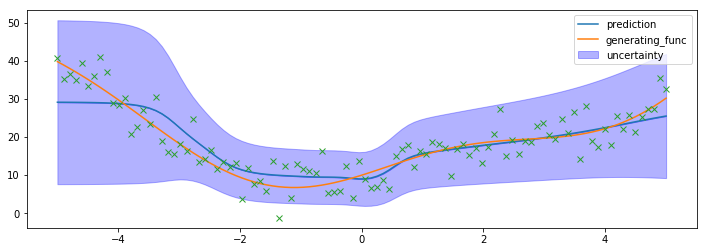

RSME is 4.700848579406738
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 11.955792427062988
COVERAGE/MEAN_VAR is 0.08196863620529943


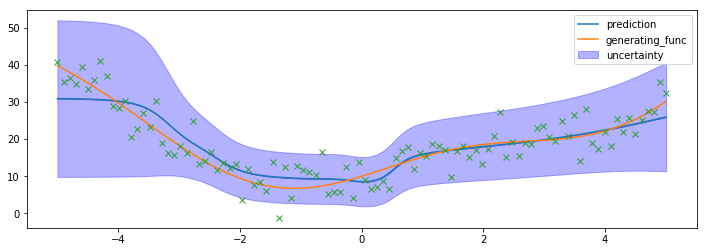

RSME is 4.4192399978637695
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.963166236877441
COVERAGE/MEAN_VAR is 0.08847808917985339


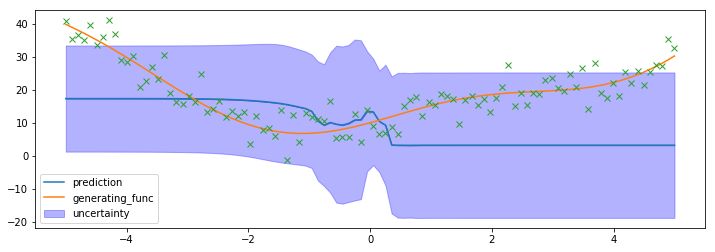

RSME is 14.110116958618164
COVERAGE PROBABILITY is 0.81
MEAN VARIANCE is 19.570898056030273
COVERAGE/MEAN_VAR is 0.04138798320245806


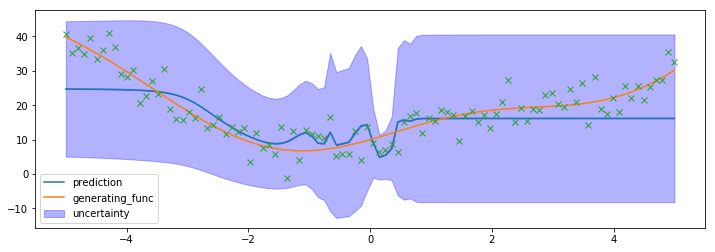

RSME is 6.5666351318359375
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 20.5443172454834
COVERAGE/MEAN_VAR is 0.048675260805751366


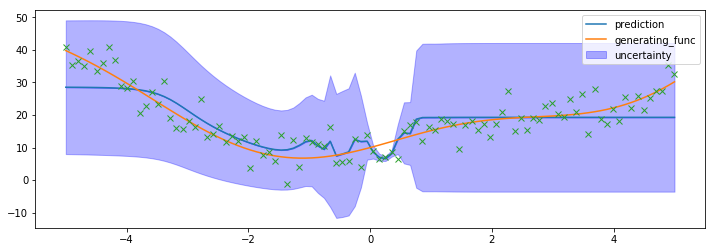

RSME is 5.260616302490234
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 18.563865661621094
COVERAGE/MEAN_VAR is 0.053329409835513104


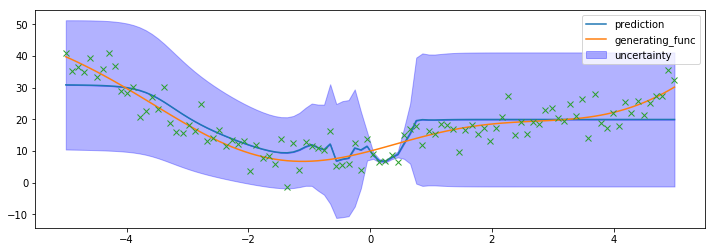

RSME is 4.861324787139893
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 17.247400283813477
COVERAGE/MEAN_VAR is 0.05682015746568605


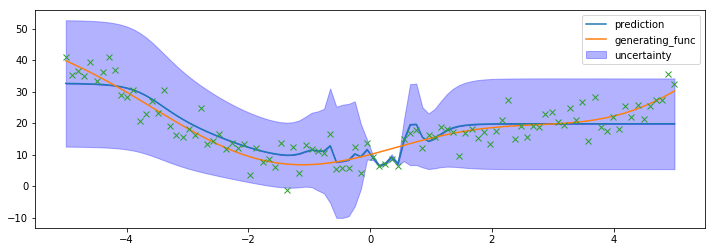

RSME is 4.615617752075195
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 13.606830596923828
COVERAGE/MEAN_VAR is 0.07128772516792362


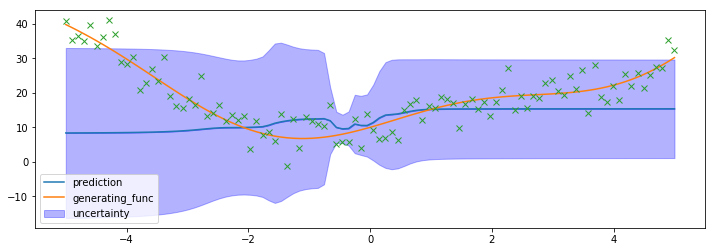

RSME is 11.751015663146973
COVERAGE PROBABILITY is 0.88
MEAN VARIANCE is 17.324241638183594
COVERAGE/MEAN_VAR is 0.05079587426559735


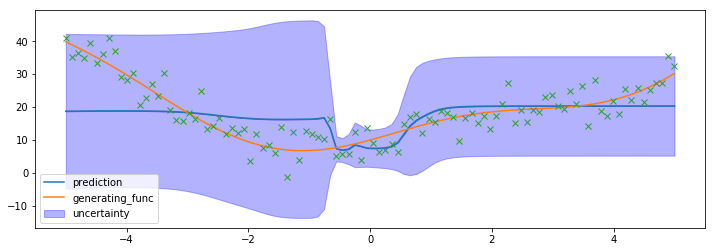

RSME is 7.8052897453308105
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 18.5789852142334
COVERAGE/MEAN_VAR is 0.052747767905494646


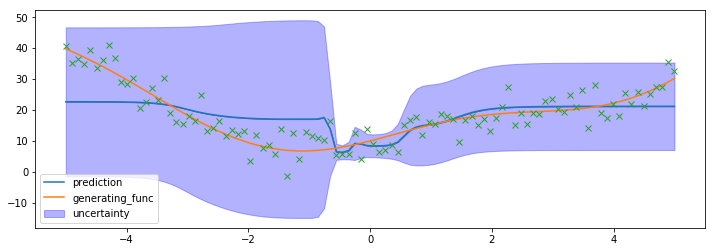

RSME is 6.846412181854248
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 18.602859497070312
COVERAGE/MEAN_VAR is 0.052142521430791934


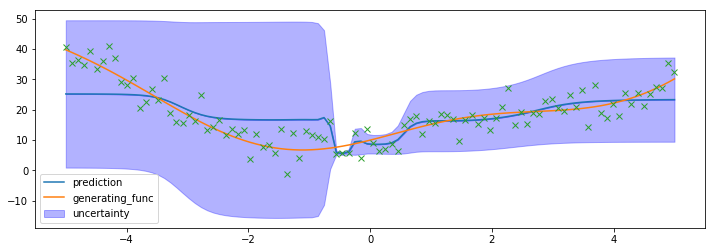

RSME is 6.027305603027344
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 17.967021942138672
COVERAGE/MEAN_VAR is 0.05454437597705452


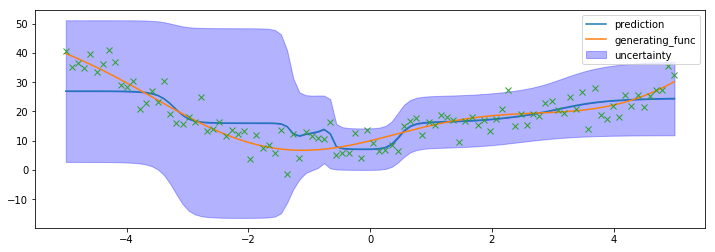

RSME is 5.340404033660889
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 16.76622772216797
COVERAGE/MEAN_VAR is 0.05904727147962102


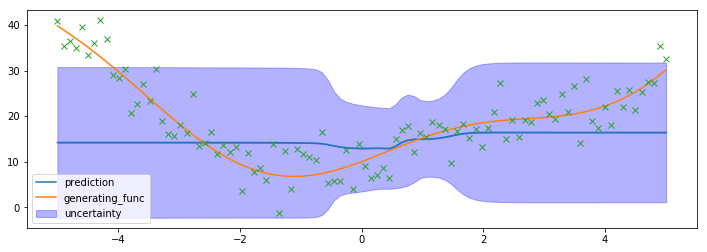

RSME is 9.628800392150879
COVERAGE PROBABILITY is 0.89
MEAN VARIANCE is 14.581247329711914
COVERAGE/MEAN_VAR is 0.06103730221943804


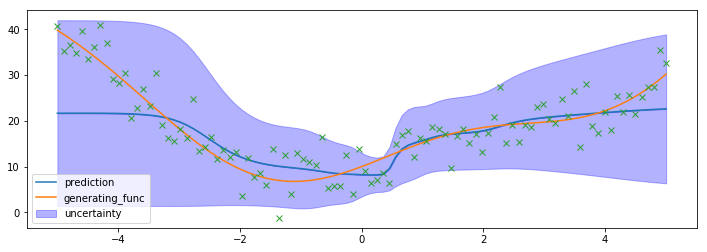

RSME is 6.258612155914307
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 12.304259300231934
COVERAGE/MEAN_VAR is 0.07964721614583717


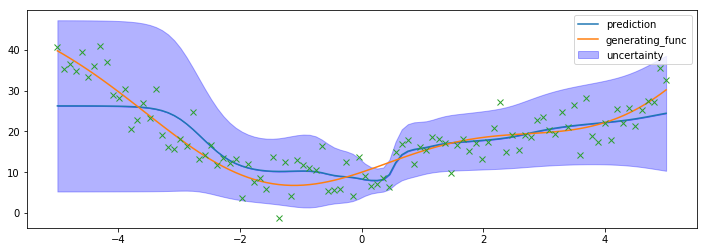

RSME is 5.177226543426514
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 11.03772258758545
COVERAGE/MEAN_VAR is 0.0869744634712734


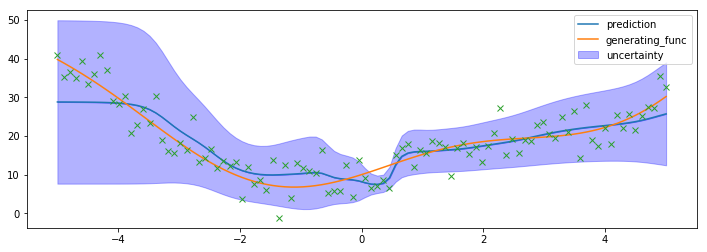

RSME is 4.595327377319336
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.143678665161133
COVERAGE/MEAN_VAR is 0.0946402219243358


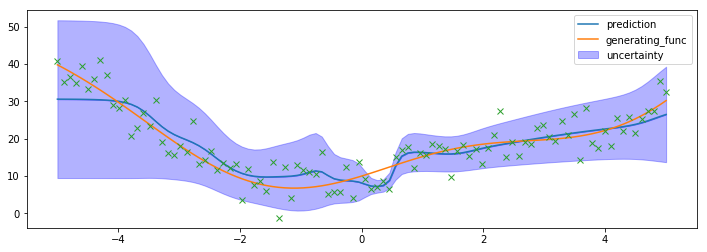

RSME is 4.233238220214844
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 9.487607955932617
COVERAGE/MEAN_VAR is 0.09907660649196791


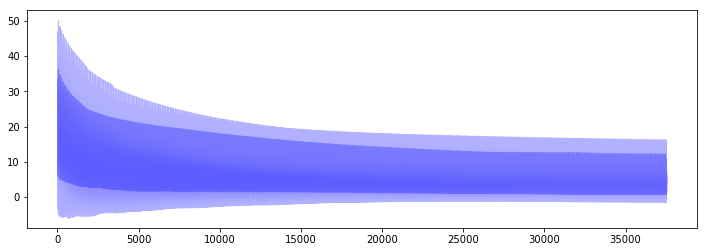

In [24]:
import numpy as np
n_samples = 20
num_epochs = 25#15#10#15
num_eps = 15#25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta = []


bad_seeds = [2,4,10,13,15,16,9]
very_bad_seeds = [16,10]
for i in range(n_samples):
    silent = False
    if i == n_samples - 1:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        if i not in very_bad_seeds:
            params['seed'] = seed + 100+i
        else:
            params['seed'] = seed + 100+i + 42 + i

    gauss_tmp = GaussianLossEstimator(**params)

    errors = train_and_plot(gauss_tmp,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

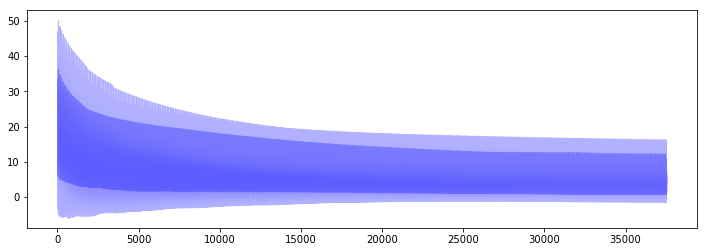

In [25]:
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

In [ ]:
#for i in range(n_samples):
#    plt.plot(errors_meta[i])
#    plt.show()
#    print(i)

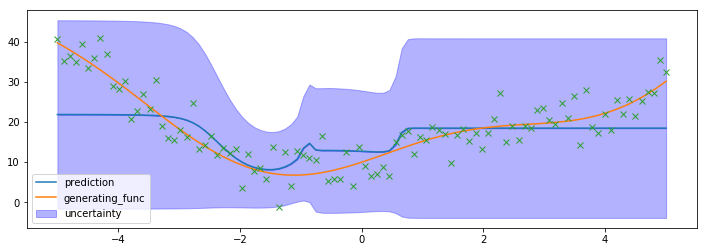

RSME is 6.80657434463501
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 19.754009246826172
COVERAGE/MEAN_VAR is 0.05011640865557764


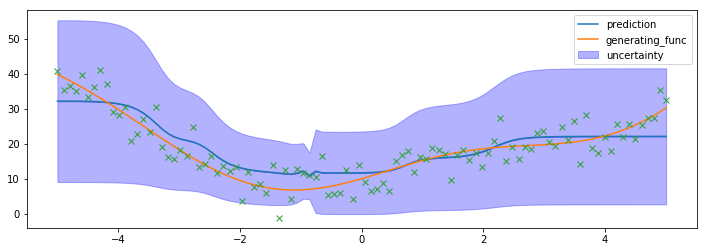

RSME is 4.76524019241333
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 16.031923294067383
COVERAGE/MEAN_VAR is 0.06175179246063071


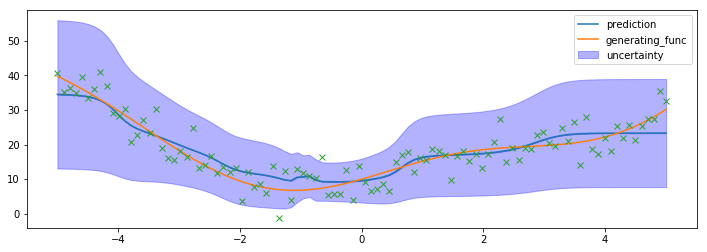

RSME is 4.136051654815674
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 12.51606559753418
COVERAGE/MEAN_VAR is 0.07829936591200609


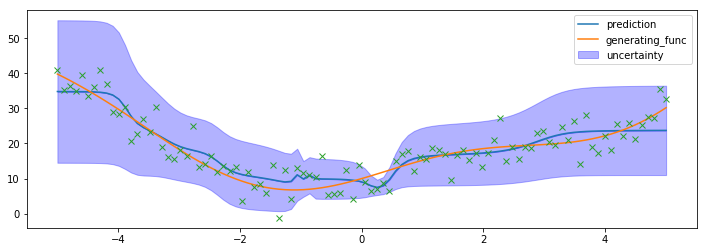

RSME is 3.9843268394470215
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.647810935974121
COVERAGE/MEAN_VAR is 0.09015937696231961


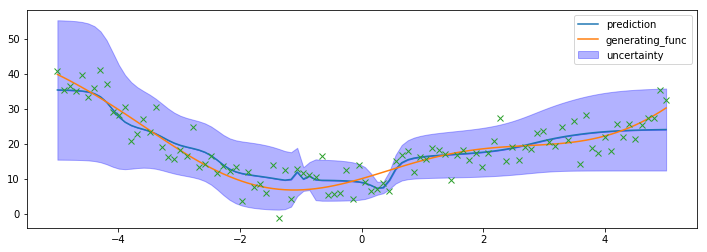

RSME is 3.9408674240112305
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.279212951660156
COVERAGE/MEAN_VAR is 0.10237937257707122


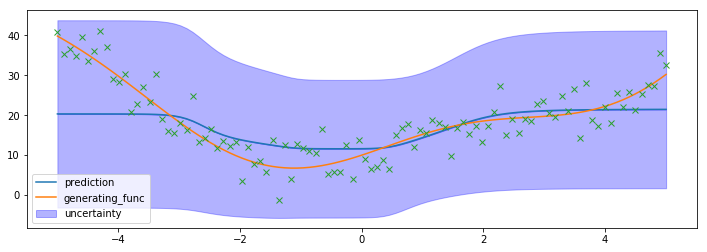

RSME is 6.940093994140625
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 19.609420776367188
COVERAGE/MEAN_VAR is 0.05099589689080345


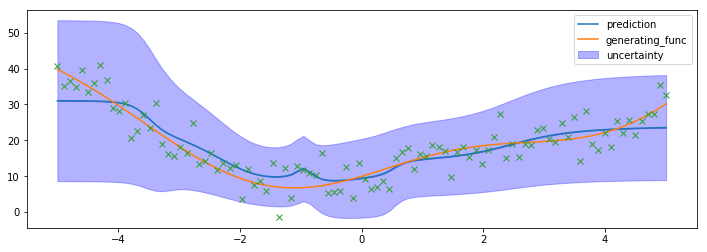

RSME is 4.4323859214782715
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 13.409555435180664
COVERAGE/MEAN_VAR is 0.07382795088065959


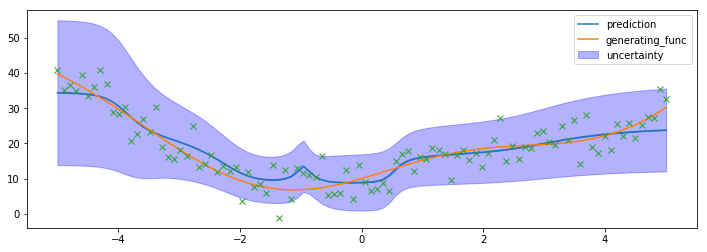

RSME is 4.033265113830566
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.553706169128418
COVERAGE/MEAN_VAR is 0.09096330564974238


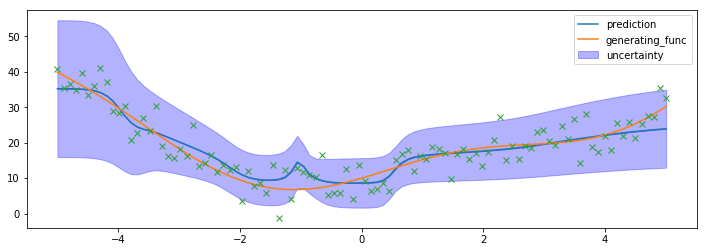

RSME is 3.958413600921631
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 9.630350112915039
COVERAGE/MEAN_VAR is 0.09760808163551477


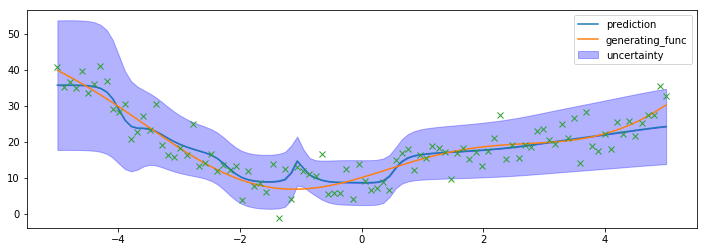

RSME is 3.848616123199463
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 8.983713150024414
COVERAGE/MEAN_VAR is 0.10574692046989705


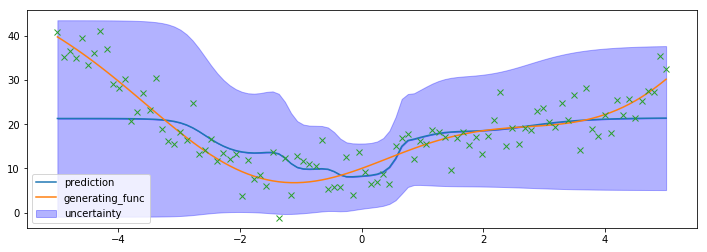

RSME is 6.621693134307861
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 14.994965553283691
COVERAGE/MEAN_VAR is 0.066022159002773


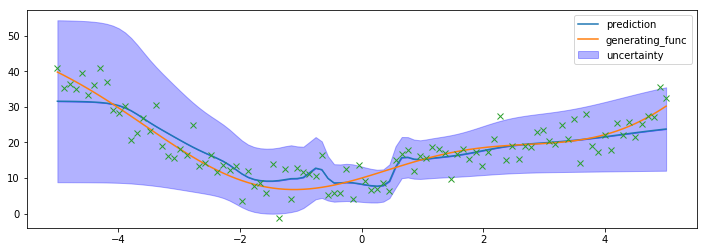

RSME is 4.244288444519043
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 10.692435264587402
COVERAGE/MEAN_VAR is 0.08884786079989967


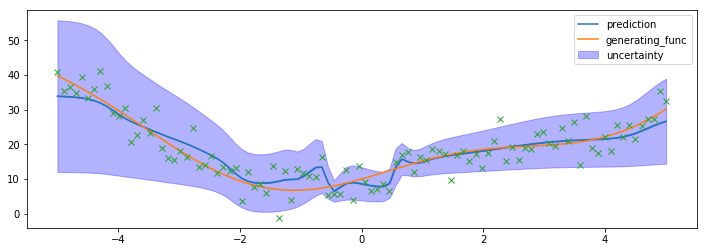

RSME is 3.835948944091797
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.412193298339844
COVERAGE/MEAN_VAR is 0.10199535534075019


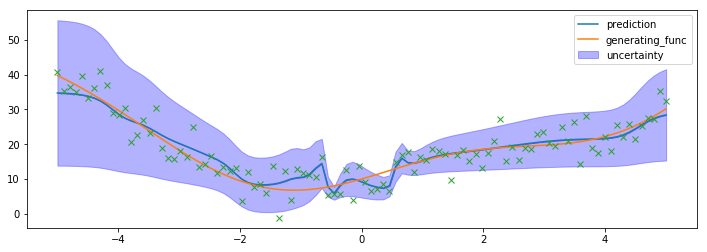

RSME is 3.630913496017456
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.043096542358398
COVERAGE/MEAN_VAR is 0.10615832701810748


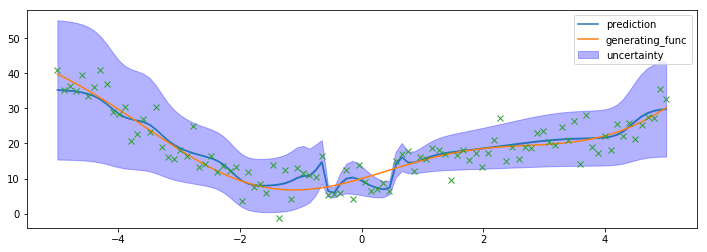

RSME is 3.538519859313965
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 8.664534568786621
COVERAGE/MEAN_VAR is 0.10964235787370603


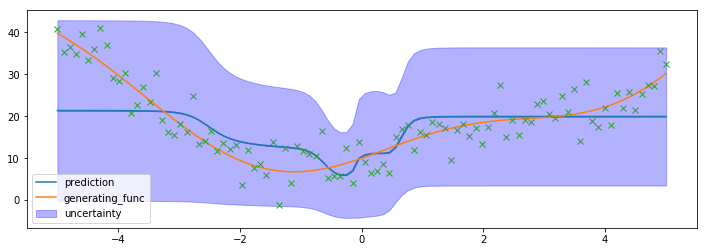

RSME is 6.855177402496338
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 16.8016300201416
COVERAGE/MEAN_VAR is 0.059518034785982755


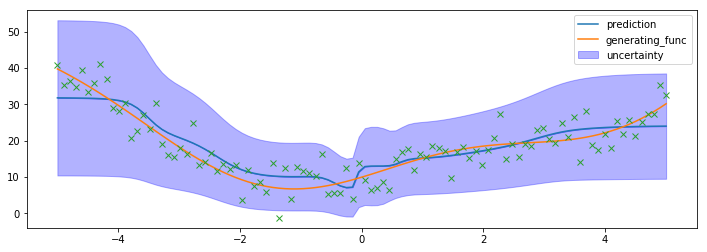

RSME is 4.470373153686523
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 13.043767929077148
COVERAGE/MEAN_VAR is 0.07589831445813242


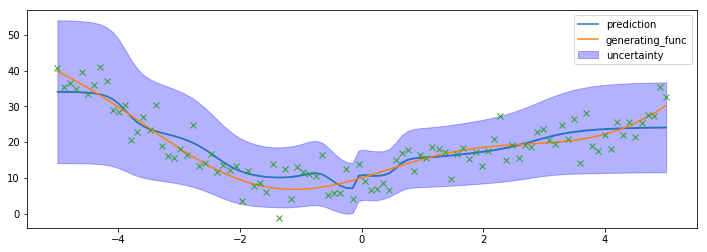

RSME is 4.091231822967529
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 11.213788986206055
COVERAGE/MEAN_VAR is 0.08739240601062549


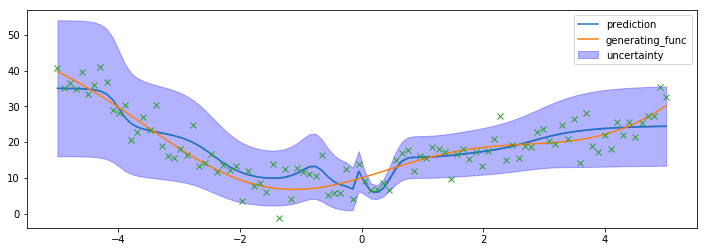

RSME is 3.9182591438293457
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 9.722574234008789
COVERAGE/MEAN_VAR is 0.09976781628542546


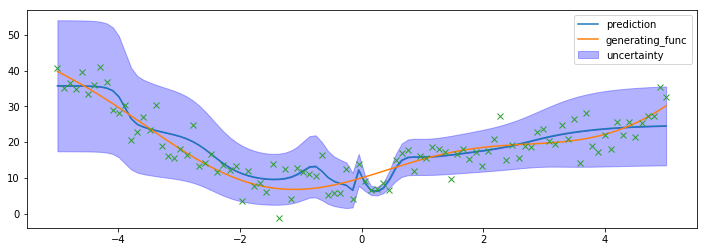

RSME is 3.893643856048584
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.262401580810547
COVERAGE/MEAN_VAR is 0.10256519237604315


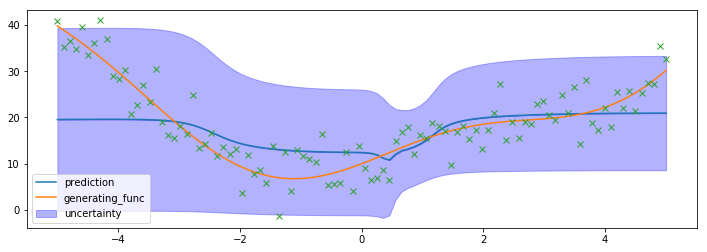

RSME is 7.293237686157227
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 14.285338401794434
COVERAGE/MEAN_VAR is 0.06650174978568706


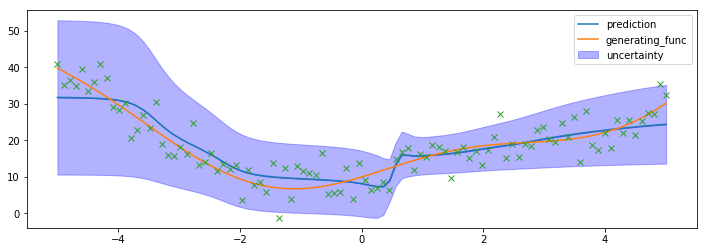

RSME is 4.289700508117676
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.764244079589844
COVERAGE/MEAN_VAR is 0.08918415384320971


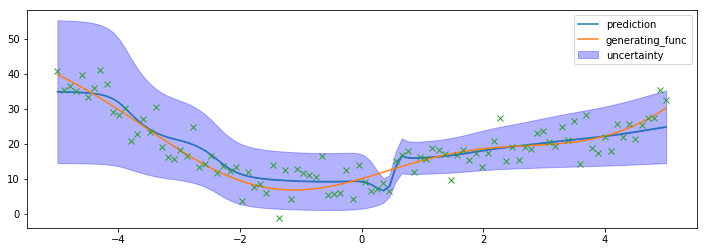

RSME is 3.958120346069336
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.425373077392578
COVERAGE/MEAN_VAR is 0.10185273220670996


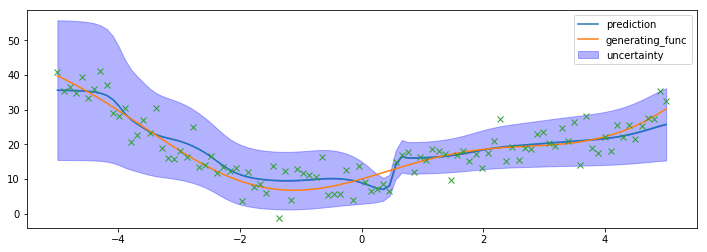

RSME is 3.8381547927856445
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.08185863494873
COVERAGE/MEAN_VAR is 0.1057052348630198


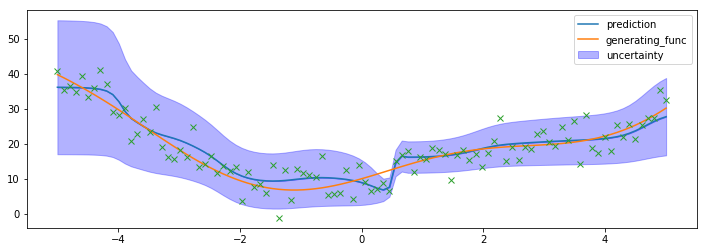

RSME is 3.72408127784729
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 8.805124282836914
COVERAGE/MEAN_VAR is 0.10902742189241406


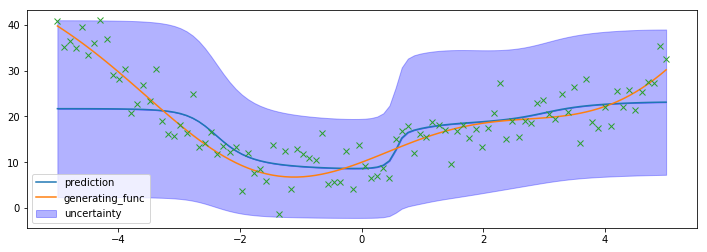

RSME is 6.265174388885498
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 15.399985313415527
COVERAGE/MEAN_VAR is 0.06428577559340738


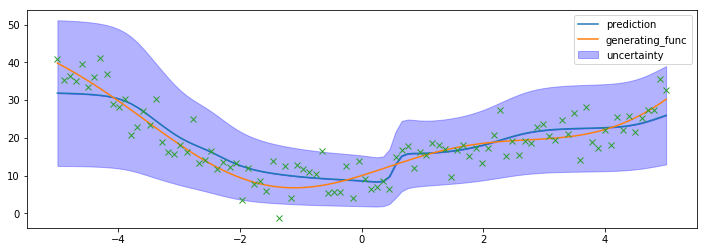

RSME is 4.235555648803711
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 11.1703519821167
COVERAGE/MEAN_VAR is 0.08773223991230912


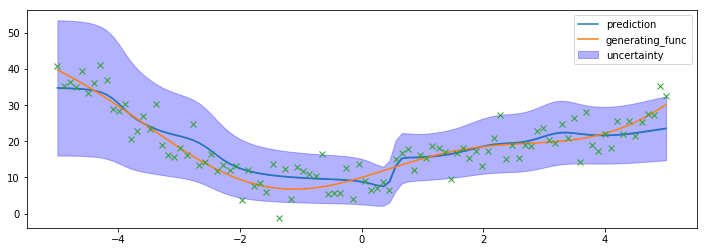

RSME is 4.11003303527832
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 9.402588844299316
COVERAGE/MEAN_VAR is 0.09890892980648075


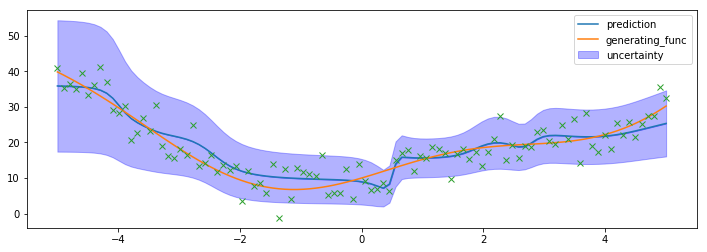

RSME is 3.881059169769287
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 8.835306167602539
COVERAGE/MEAN_VAR is 0.1063913329282022


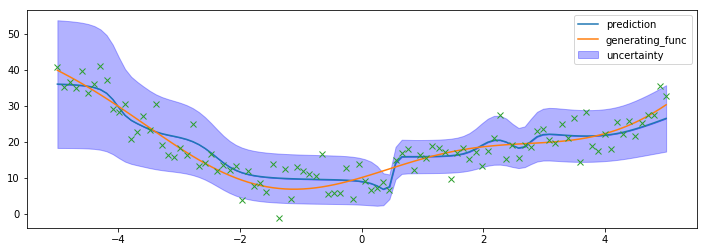

RSME is 3.757031202316284
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 8.191367149353027
COVERAGE/MEAN_VAR is 0.11353416139739915


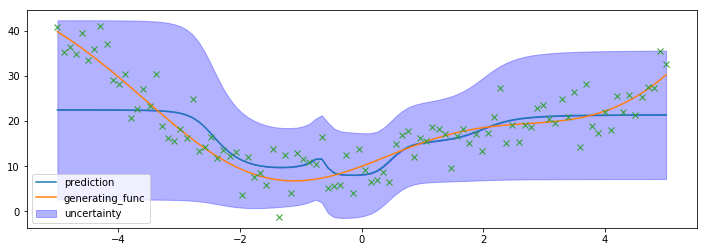

RSME is 6.138866901397705
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 13.353283882141113
COVERAGE/MEAN_VAR is 0.07413906637033615


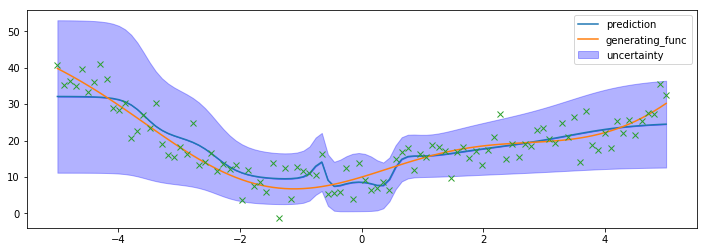

RSME is 4.148317813873291
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.518730163574219
COVERAGE/MEAN_VAR is 0.09221645435482853


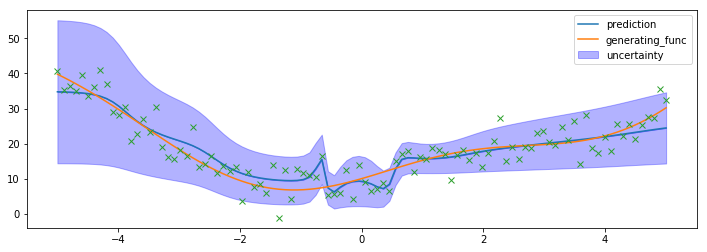

RSME is 3.8630383014678955
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.118624687194824
COVERAGE/MEAN_VAR is 0.10418237756117692


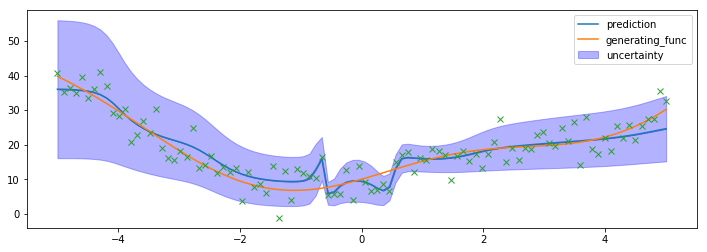

RSME is 3.772721529006958
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 8.675082206726074
COVERAGE/MEAN_VAR is 0.10950904871696017


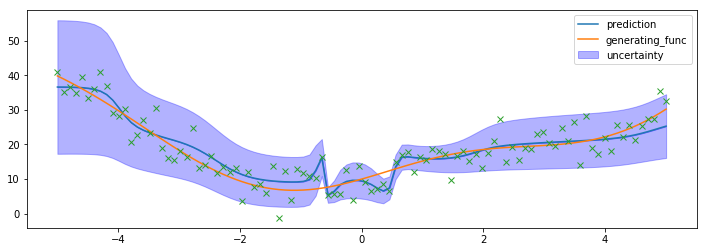

RSME is 3.7000885009765625
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 8.407438278198242
COVERAGE/MEAN_VAR is 0.1118057568662219


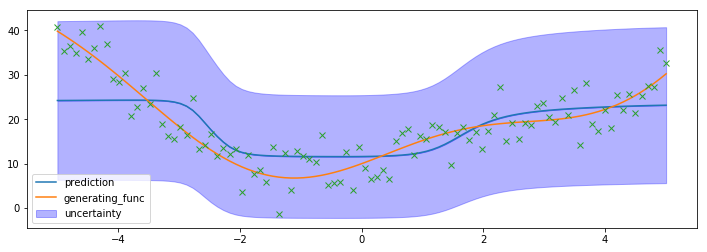

RSME is 5.967311859130859
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 16.071060180664062
COVERAGE/MEAN_VAR is 0.062223648518419


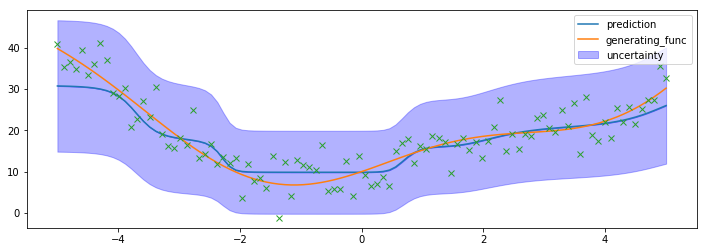

RSME is 4.316629409790039
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 12.181404113769531
COVERAGE/MEAN_VAR is 0.08127141918565288


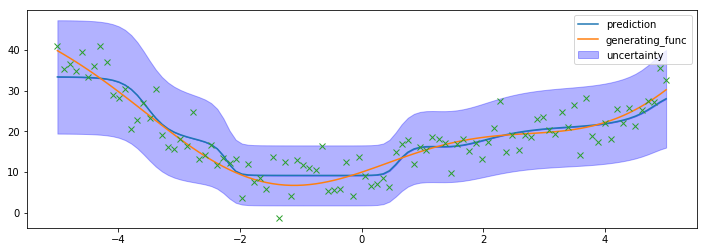

RSME is 3.935432195663452
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 9.730289459228516
COVERAGE/MEAN_VAR is 0.10174414688774264


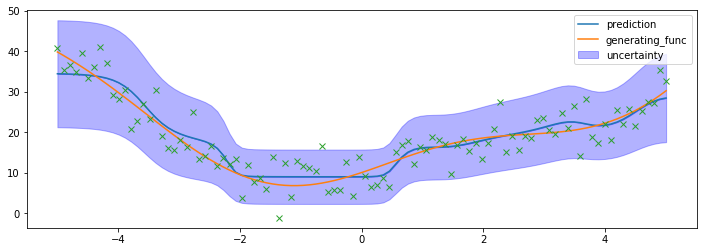

RSME is 3.829841136932373
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 8.984659194946289
COVERAGE/MEAN_VAR is 0.10907481060063275


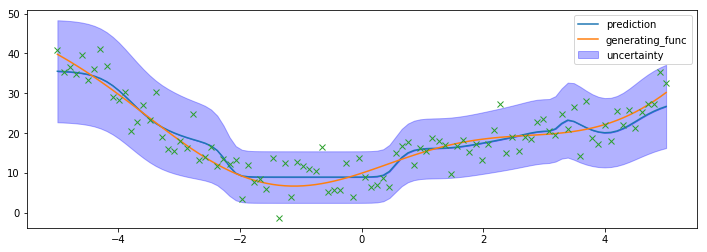

RSME is 3.7824461460113525
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 8.639500617980957
COVERAGE/MEAN_VAR is 0.11227500788427376


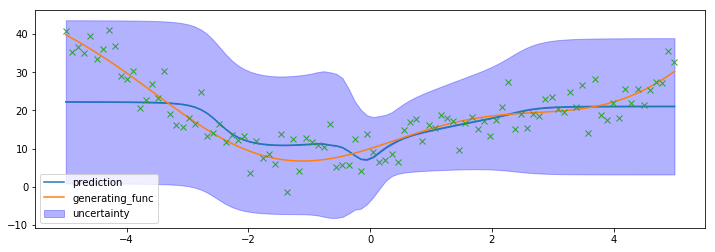

RSME is 6.300792217254639
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 17.037433624267578
COVERAGE/MEAN_VAR is 0.058694285891487306


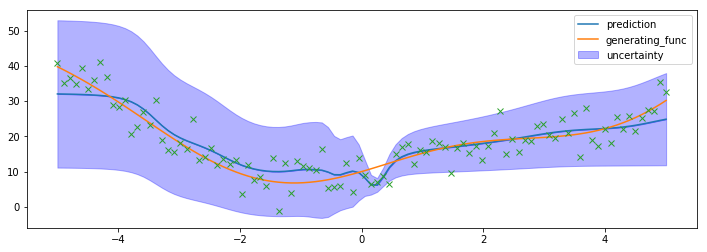

RSME is 4.208204746246338
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.134923934936523
COVERAGE/MEAN_VAR is 0.0799345760386156


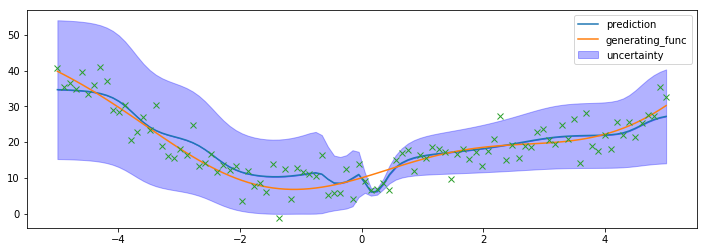

RSME is 3.8701329231262207
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.50875473022461
COVERAGE/MEAN_VAR is 0.09135240327180814


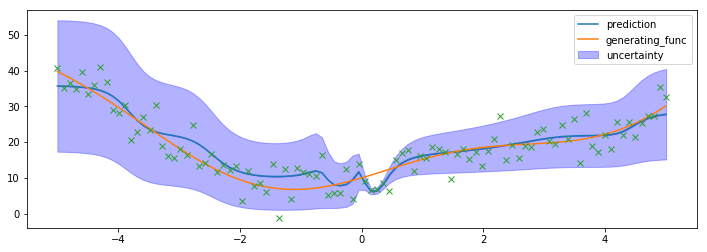

RSME is 3.7835965156555176
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.896058082580566
COVERAGE/MEAN_VAR is 0.09700832311097991


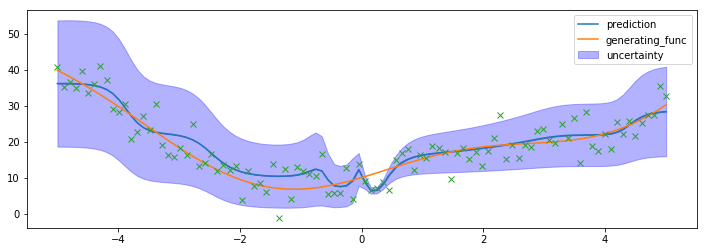

RSME is 3.7425642013549805
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.539533615112305
COVERAGE/MEAN_VAR is 0.10063385053533336


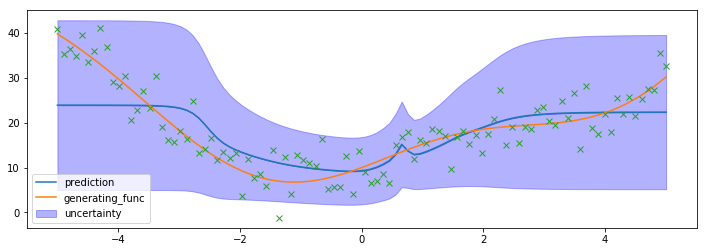

RSME is 5.959514617919922
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 13.766271591186523
COVERAGE/MEAN_VAR is 0.07191489674181789


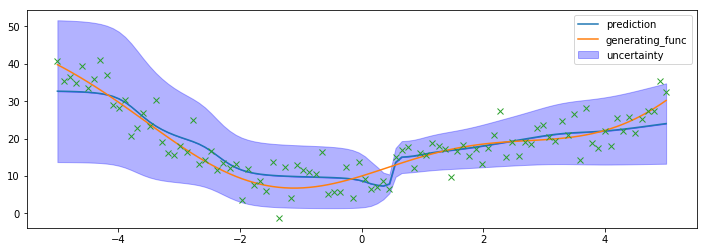

RSME is 4.158346652984619
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.552315711975098
COVERAGE/MEAN_VAR is 0.10049919087122637


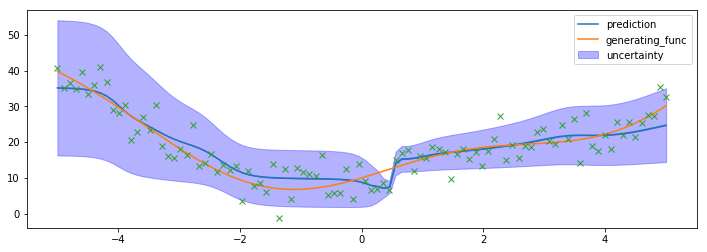

RSME is 3.9130938053131104
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.008288383483887
COVERAGE/MEAN_VAR is 0.10545843556049597


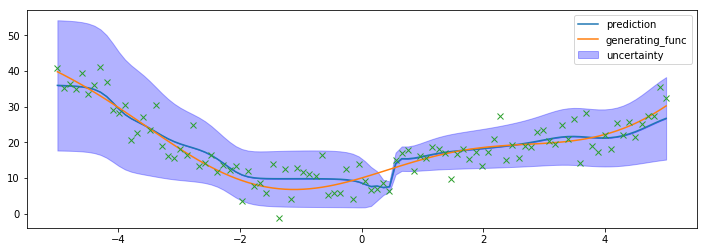

RSME is 3.7374284267425537
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 8.742191314697266
COVERAGE/MEAN_VAR is 0.11095616248631482


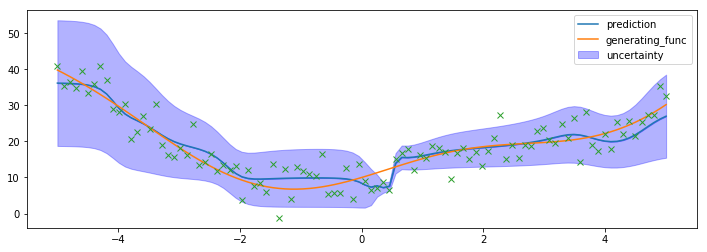

RSME is 3.72914719581604
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 8.359107971191406
COVERAGE/MEAN_VAR is 0.11364849015876492


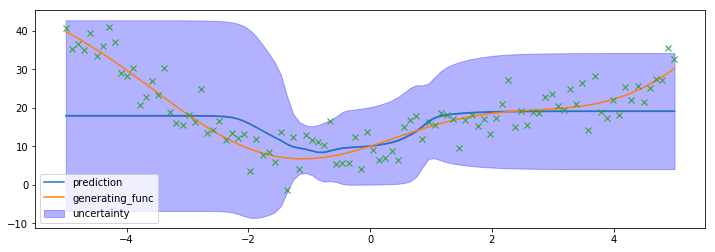

RSME is 7.859014511108398
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 16.801712036132812
COVERAGE/MEAN_VAR is 0.05892256681170121


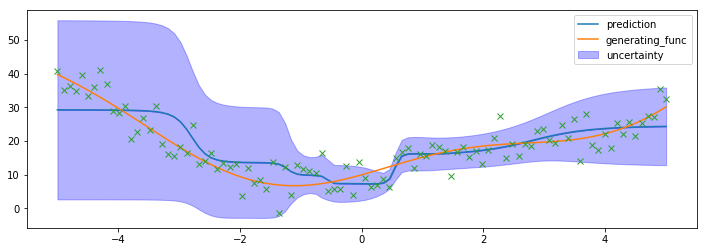

RSME is 5.143494606018066
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 12.59096908569336
COVERAGE/MEAN_VAR is 0.07624512406203995


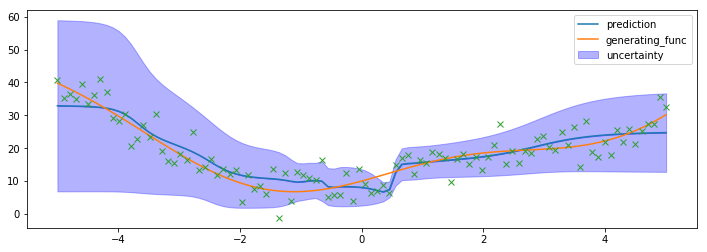

RSME is 4.132816791534424
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 11.024192810058594
COVERAGE/MEAN_VAR is 0.08708120553951901


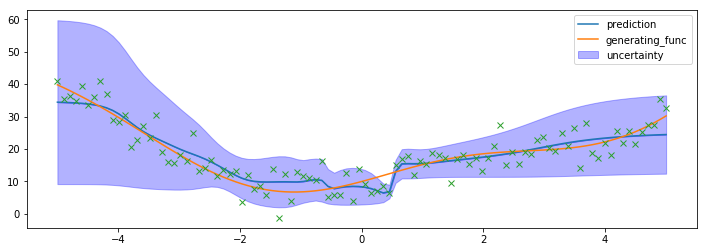

RSME is 3.9273953437805176
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.259394645690918
COVERAGE/MEAN_VAR is 0.0935727723860601


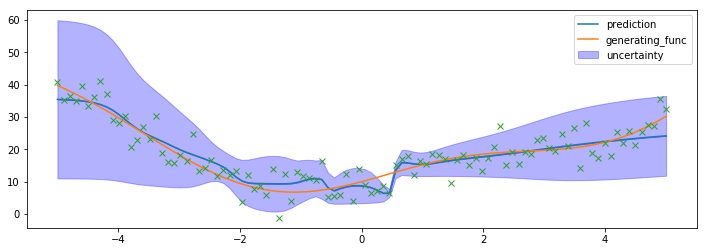

RSME is 3.8362276554107666
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.975414276123047
COVERAGE/MEAN_VAR is 0.09623660465889992


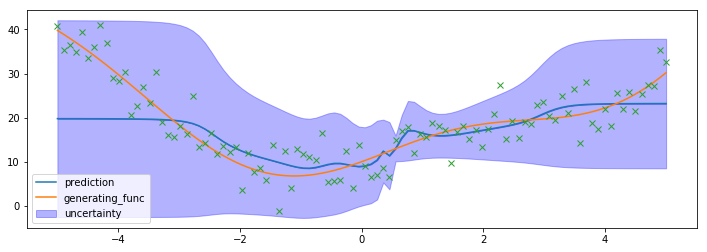

RSME is 6.831903457641602
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 13.657695770263672
COVERAGE/MEAN_VAR is 0.07175441717875375


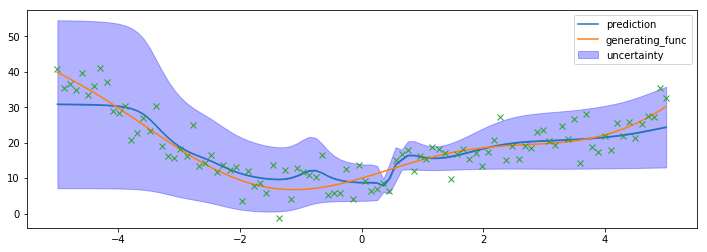

RSME is 4.322235584259033
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 10.590950965881348
COVERAGE/MEAN_VAR is 0.08969921615730413


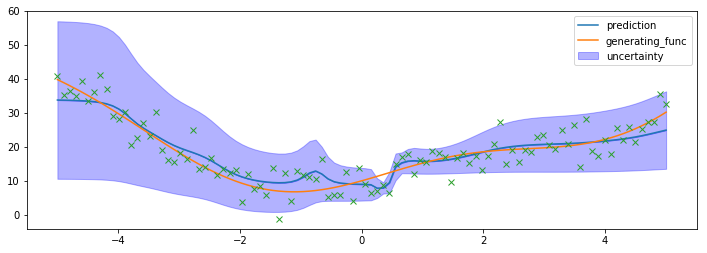

RSME is 3.9489622116088867
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 10.155701637268066
COVERAGE/MEAN_VAR is 0.09354351219947366


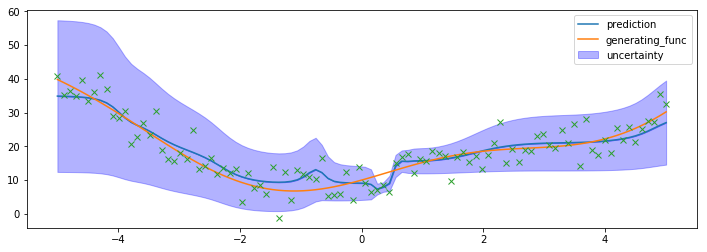

RSME is 3.743440628051758
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.9275541305542
COVERAGE/MEAN_VAR is 0.09569325812852222


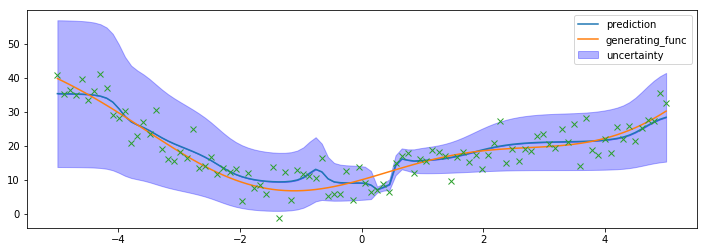

RSME is 3.631289482116699
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.819552421569824
COVERAGE/MEAN_VAR is 0.09674575369781734


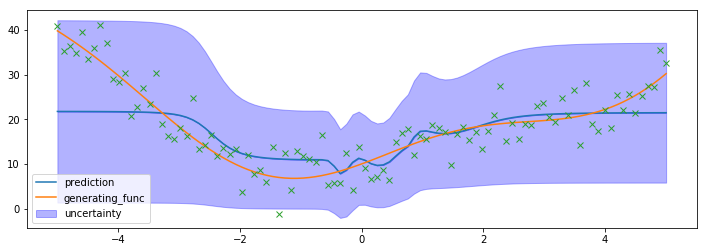

RSME is 6.395489692687988
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 14.836451530456543
COVERAGE/MEAN_VAR is 0.06672754586686107


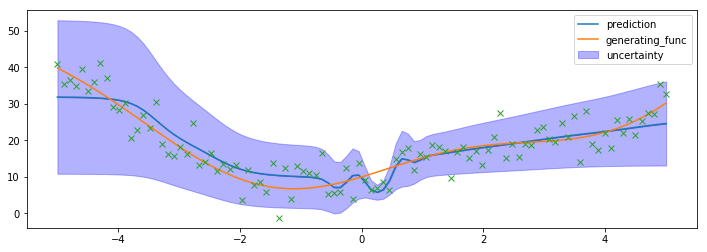

RSME is 4.2747344970703125
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.40909194946289
COVERAGE/MEAN_VAR is 0.09318776361179631


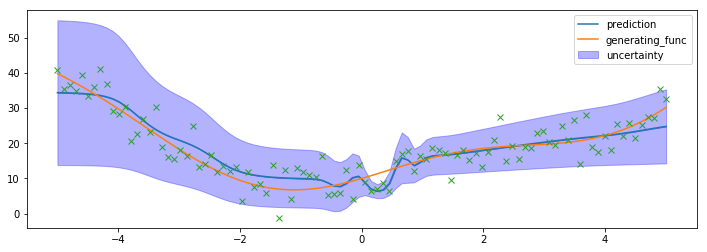

RSME is 4.001229763031006
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.627279281616211
COVERAGE/MEAN_VAR is 0.0997166459929307


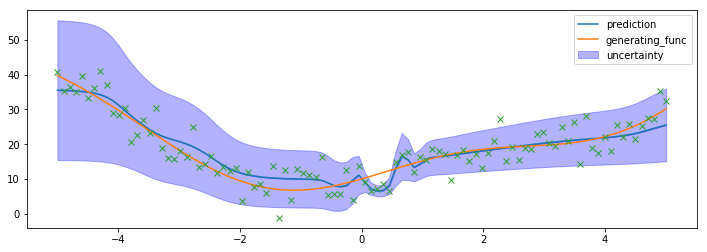

RSME is 3.8541996479034424
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.236856460571289
COVERAGE/MEAN_VAR is 0.10284884300792128


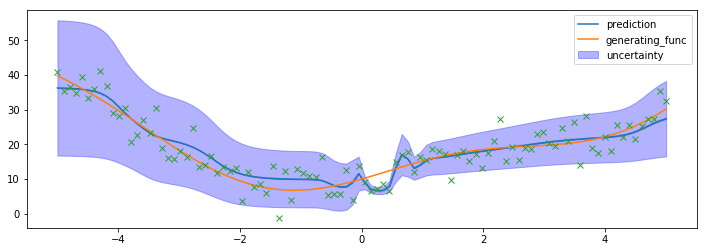

RSME is 3.6887831687927246
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 8.879359245300293
COVERAGE/MEAN_VAR is 0.10698970204441499


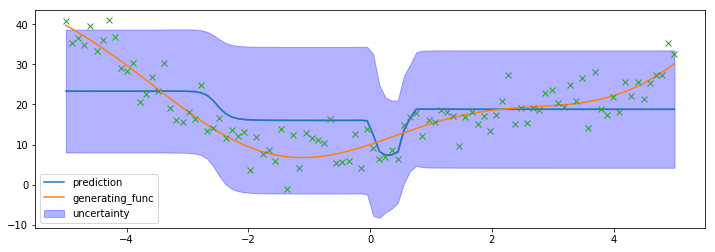

RSME is 7.18563175201416
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 15.746390342712402
COVERAGE/MEAN_VAR is 0.06096635350109292


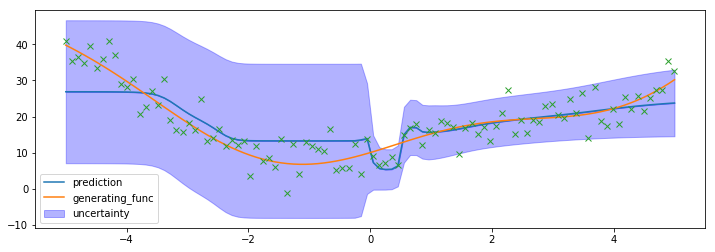

RSME is 5.325835227966309
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 13.96539306640625
COVERAGE/MEAN_VAR is 0.06945740770686468


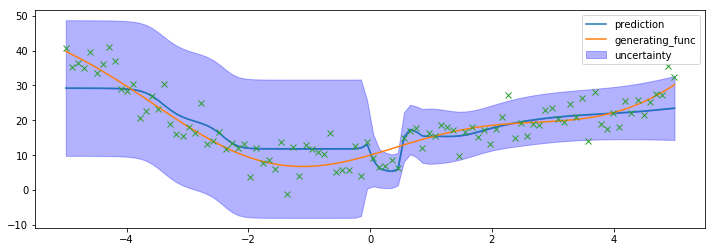

RSME is 4.721713542938232
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 13.34400749206543
COVERAGE/MEAN_VAR is 0.07269180570955001


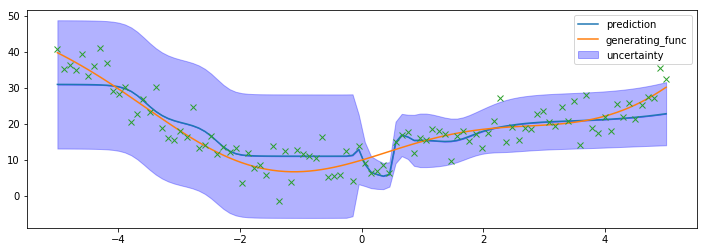

RSME is 4.476551055908203
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.124484062194824
COVERAGE/MEAN_VAR is 0.08000340427058193


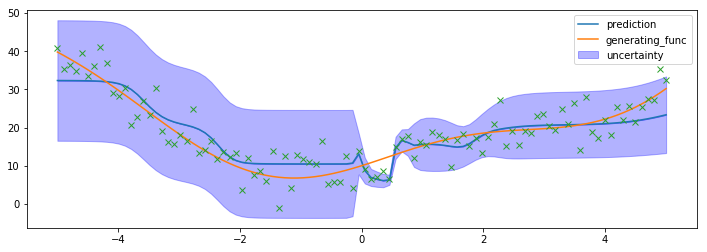

RSME is 4.318509578704834
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.837368965148926
COVERAGE/MEAN_VAR is 0.0895051191040325


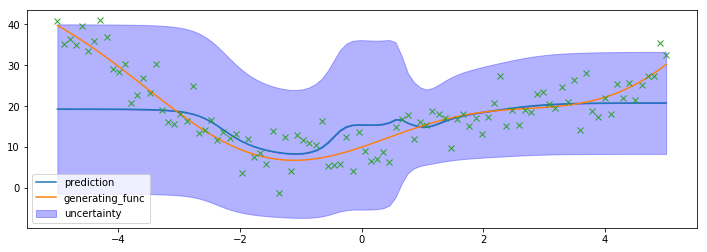

RSME is 7.367982387542725
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 15.927360534667969
COVERAGE/MEAN_VAR is 0.060901490732797124


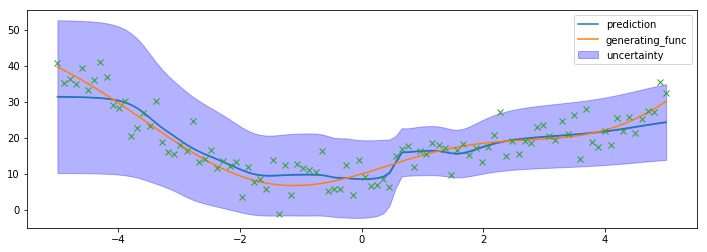

RSME is 4.211232662200928
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 11.802404403686523
COVERAGE/MEAN_VAR is 0.08303392821329639


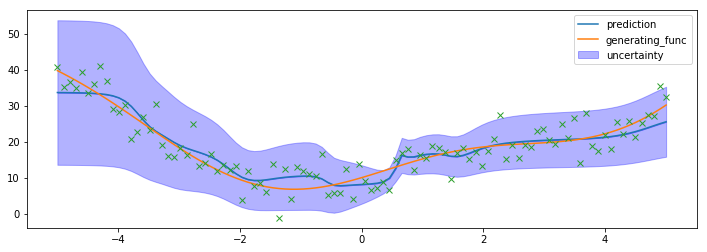

RSME is 3.938188314437866
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 9.66553783416748
COVERAGE/MEAN_VAR is 0.09725273607404639


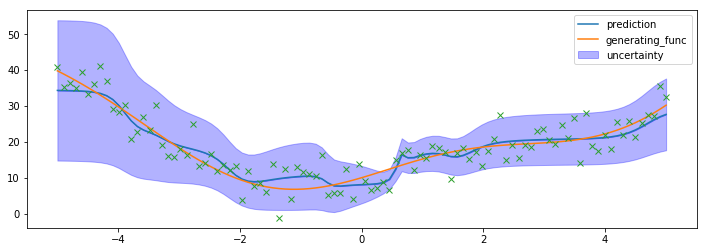

RSME is 3.691209554672241
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 8.977084159851074
COVERAGE/MEAN_VAR is 0.10471106021307415


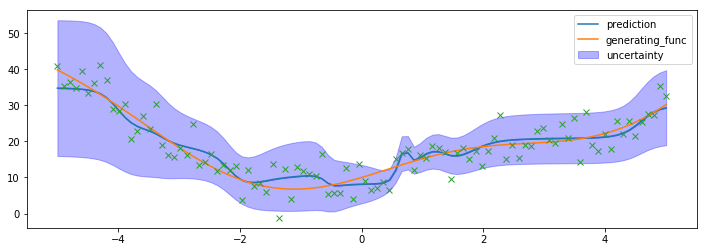

RSME is 3.593984365463257
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 8.666705131530762
COVERAGE/MEAN_VAR is 0.10961489811667398


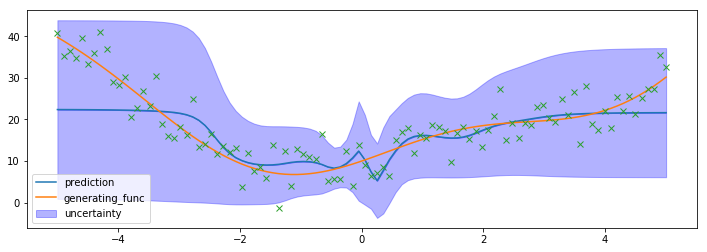

RSME is 6.102745532989502
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 14.002191543579102
COVERAGE/MEAN_VAR is 0.06998904399714433


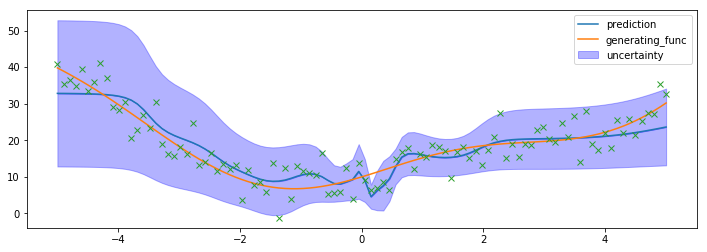

RSME is 4.208843231201172
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.139843940734863
COVERAGE/MEAN_VAR is 0.09566222179250831


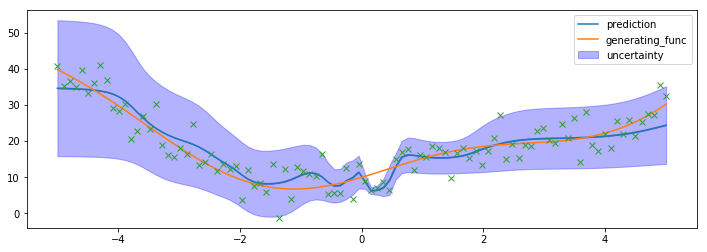

RSME is 3.9221138954162598
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.211219787597656
COVERAGE/MEAN_VAR is 0.10313509197545333


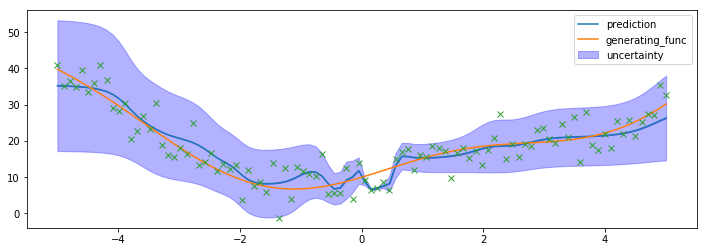

RSME is 3.728008270263672
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 8.746842384338379
COVERAGE/MEAN_VAR is 0.10861062292616801


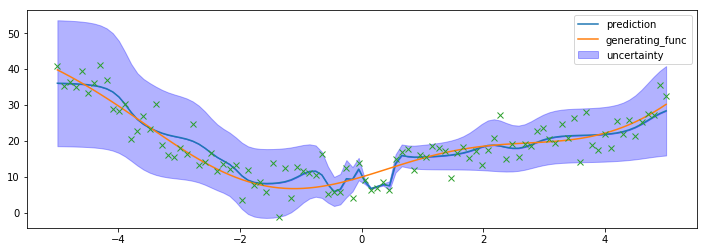

RSME is 3.562924861907959
COVERAGE PROBABILITY is 0.92
MEAN VARIANCE is 8.496051788330078
COVERAGE/MEAN_VAR is 0.10828559228695904


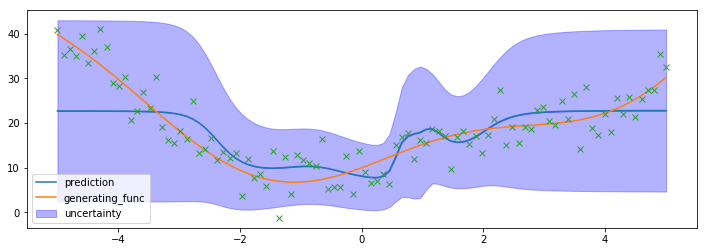

RSME is 6.040104866027832
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 14.643097877502441
COVERAGE/MEAN_VAR is 0.0676086445833999


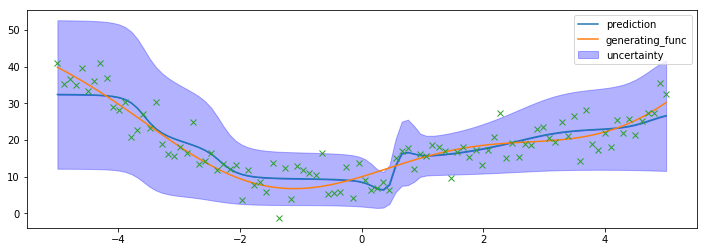

RSME is 4.0494279861450195
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.893736839294434
COVERAGE/MEAN_VAR is 0.0881240307308706


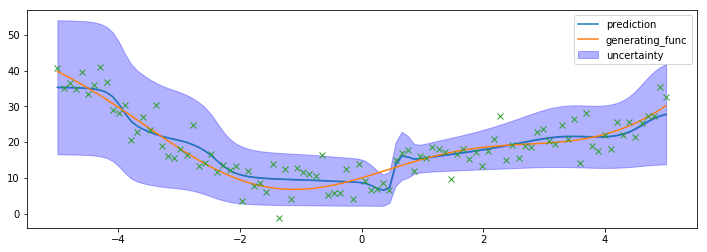

RSME is 3.682177782058716
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 9.597949028015137
COVERAGE/MEAN_VAR is 0.10002136885681386


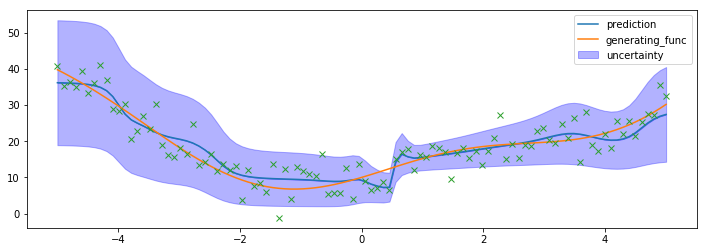

RSME is 3.6738789081573486
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 8.964618682861328
COVERAGE/MEAN_VAR is 0.10708765581243741


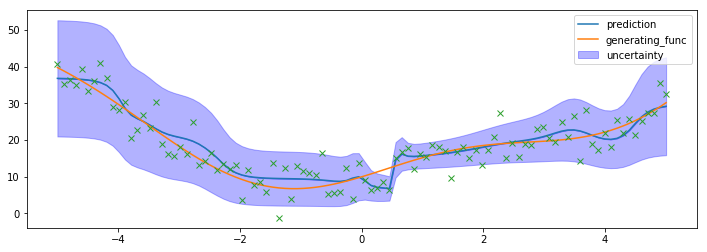

RSME is 3.601142406463623
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 8.60165786743164
COVERAGE/MEAN_VAR is 0.10928125885582025


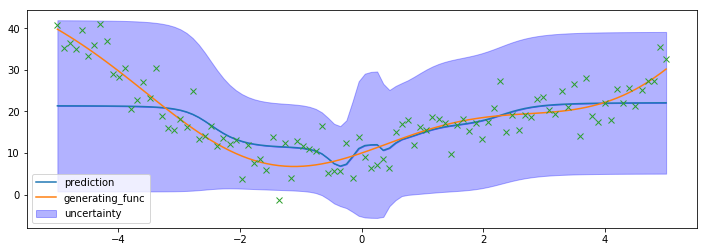

RSME is 6.483038425445557
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 15.998271942138672
COVERAGE/MEAN_VAR is 0.0618816834455969


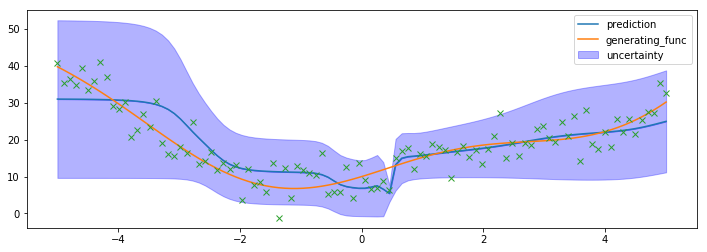

RSME is 4.885329246520996
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 11.878976821899414
COVERAGE/MEAN_VAR is 0.08165686443732784


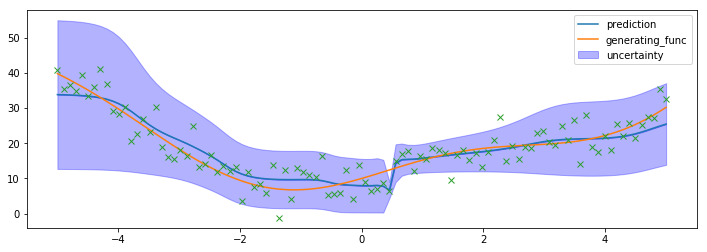

RSME is 3.997779607772827
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 10.041399955749512
COVERAGE/MEAN_VAR is 0.0966000761123549


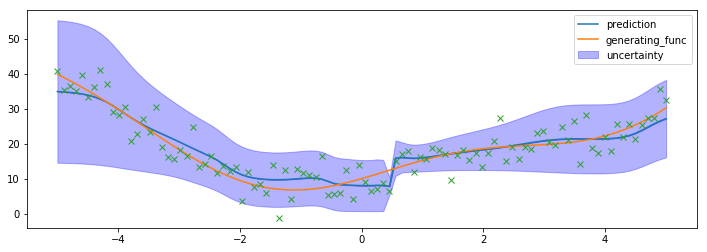

RSME is 3.8121719360351562
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 9.471251487731934
COVERAGE/MEAN_VAR is 0.10241518781931155


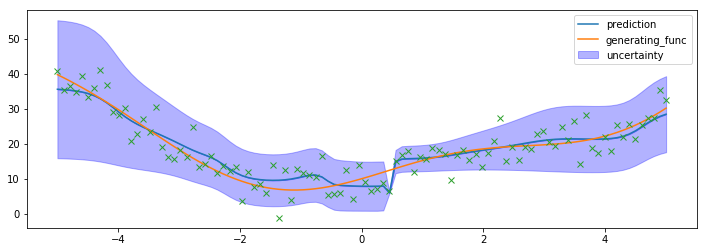

RSME is 3.6609439849853516
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.007170677185059
COVERAGE/MEAN_VAR is 0.10547152197374549


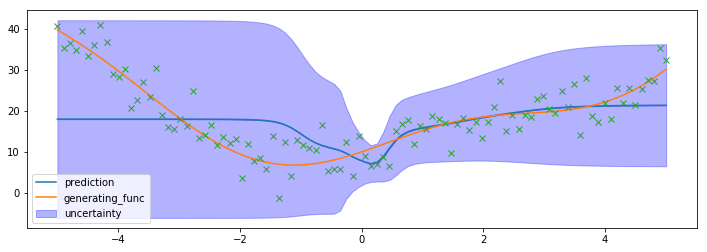

RSME is 8.00510311126709
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 16.78023910522461
COVERAGE/MEAN_VAR is 0.05959390648305155


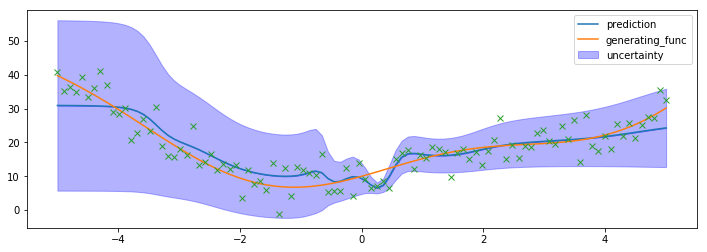

RSME is 4.341792106628418
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 11.743982315063477
COVERAGE/MEAN_VAR is 0.08174399230562969


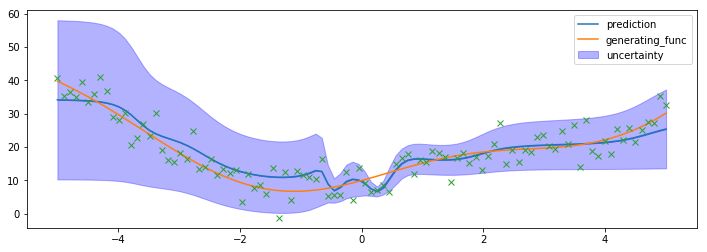

RSME is 4.0643815994262695
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 10.509893417358398
COVERAGE/MEAN_VAR is 0.09039102132386581


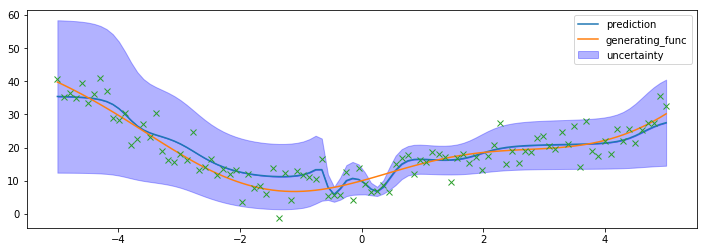

RSME is 3.836122989654541
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.905030250549316
COVERAGE/MEAN_VAR is 0.09591086306347368


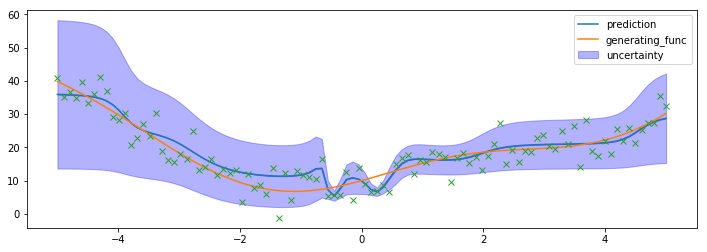

RSME is 3.7390527725219727
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 9.540210723876953
COVERAGE/MEAN_VAR is 0.0985303183762384


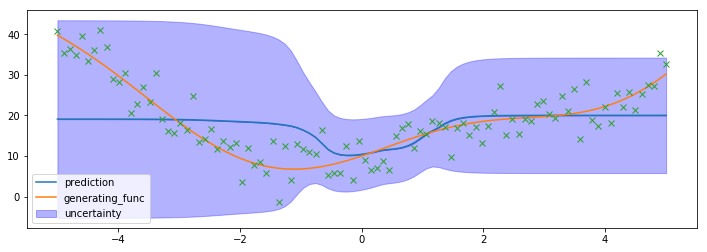

RSME is 8.03039836883545
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 16.594770431518555
COVERAGE/MEAN_VAR is 0.05965734832460753


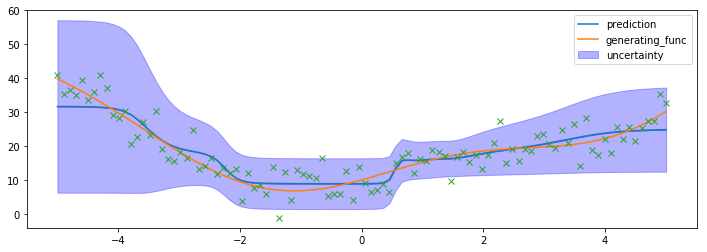

RSME is 4.184043884277344
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 11.0519380569458
COVERAGE/MEAN_VAR is 0.08686259324414777


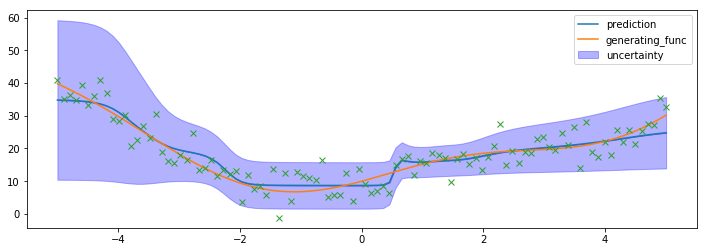

RSME is 3.883903741836548
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.765972137451172
COVERAGE/MEAN_VAR is 0.09727654212291673


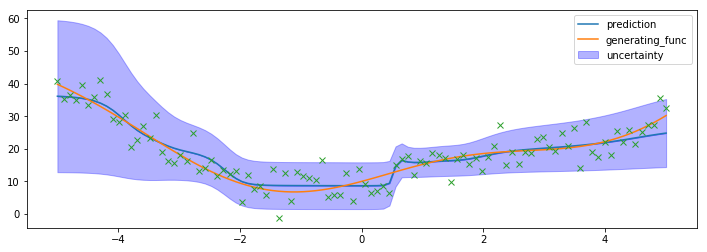

RSME is 3.8169925212860107
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.331949234008789
COVERAGE/MEAN_VAR is 0.1018008109750402


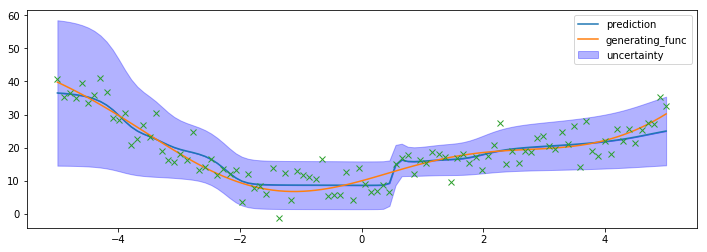

RSME is 3.782745599746704
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.024497985839844
COVERAGE/MEAN_VAR is 0.10526901346652474


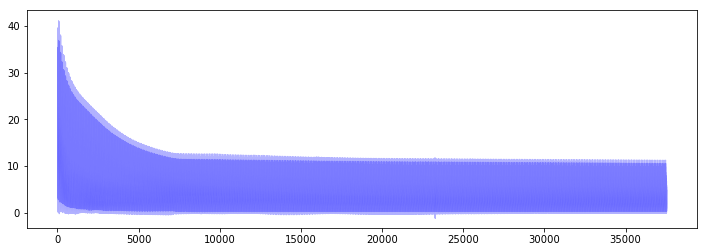

In [26]:
import numpy as np

#num_epochs = 15#10
#num_eps = 25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta_lr = []


bad_seeds = [2,4]
for i in range(n_samples):
    silent = False
    if i == n_samples:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        params['seed'] = seed + 100+i
    lr_tmp = GaussianLearningRateEstimator(**params)

    errors = train_and_plot(lr_tmp,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta_lr.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta_lr,axis=0).flatten(),np.std(errors_meta_lr,axis=0).flatten())

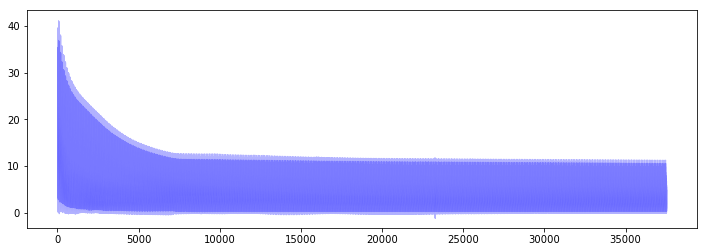

In [27]:
plot_error_tmp(np.mean(errors_meta_lr,axis=0).flatten(),np.std(errors_meta_lr,axis=0).flatten())

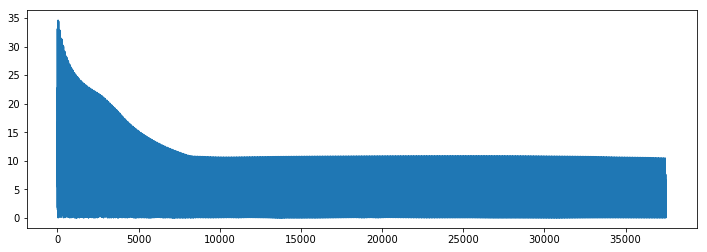

In [28]:
plt.plot(errors_meta_lr[19])

### Example of bad seed
As we can see, the GaussianLossEstimator does not cope well with bad initialisations; as soon as the learning rate is being changed, it seems that (at least for the initialisations that should be equally problematic), the issue disappears. No clue why

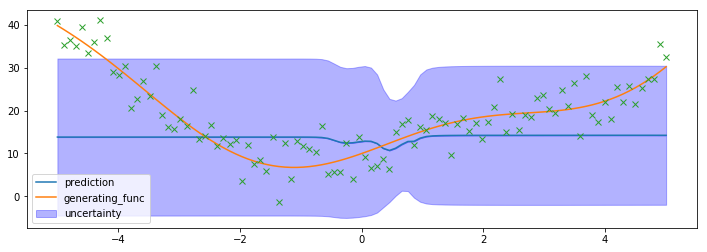

RSME is 10.195372581481934
COVERAGE PROBABILITY is 0.89
MEAN VARIANCE is 16.953123092651367
COVERAGE/MEAN_VAR is 0.05249770175890402


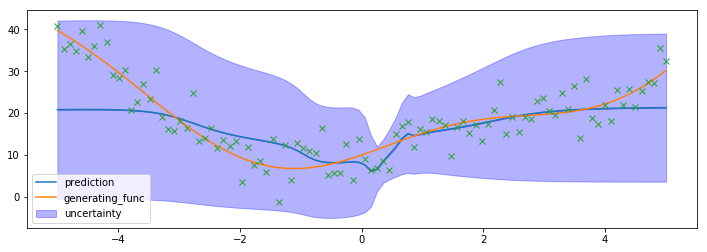

RSME is 6.718274116516113
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 15.927692413330078
COVERAGE/MEAN_VAR is 0.06278373376692584


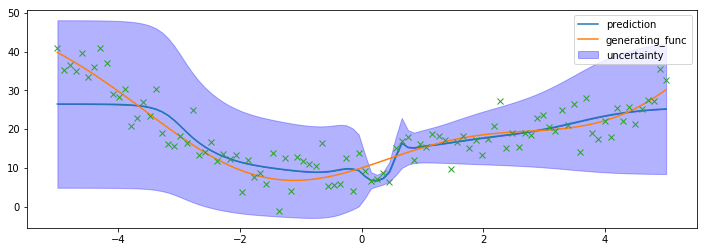

RSME is 5.019496440887451
COVERAGE PROBABILITY is 0.97
MEAN VARIANCE is 12.774383544921875
COVERAGE/MEAN_VAR is 0.075933214044258


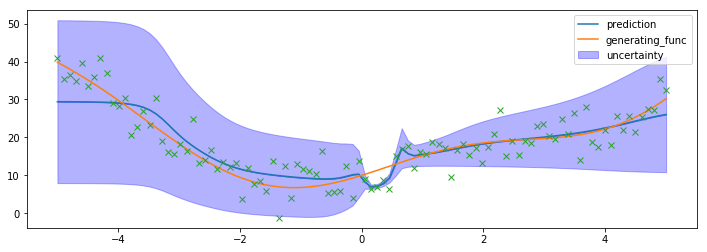

RSME is 4.490230083465576
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 11.162134170532227
COVERAGE/MEAN_VAR is 0.08421328624427199


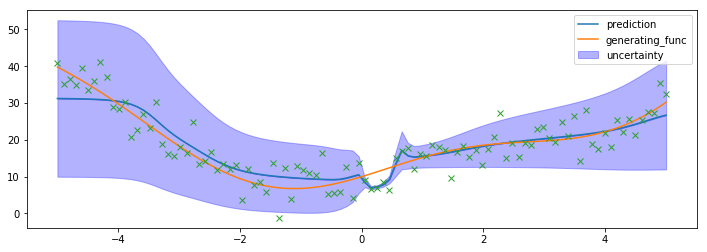

RSME is 4.2063093185424805
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 10.566790580749512
COVERAGE/MEAN_VAR is 0.08801158619479656


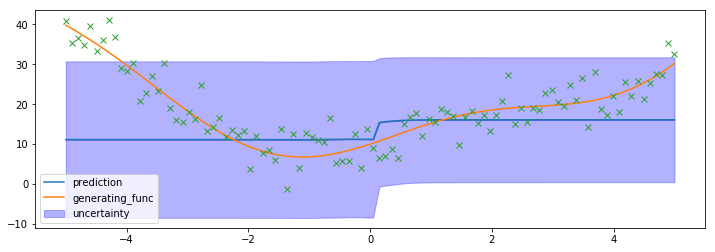

RSME is 10.67660140991211
COVERAGE PROBABILITY is 0.89
MEAN VARIANCE is 17.683815002441406
COVERAGE/MEAN_VAR is 0.050328506596406246


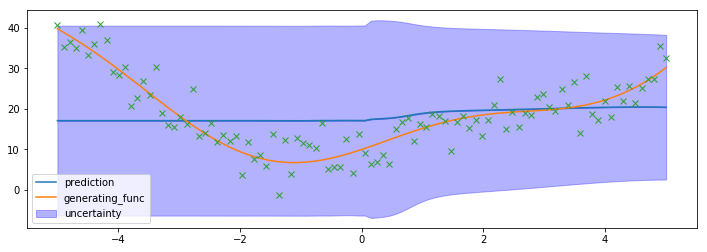

RSME is 8.958394050598145
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 21.78740882873535
COVERAGE/MEAN_VAR is 0.044980107901013026


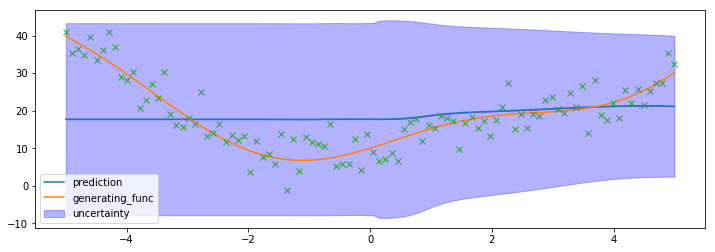

RSME is 8.881754875183105
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 23.730318069458008
COVERAGE/MEAN_VAR is 0.04214018527155964


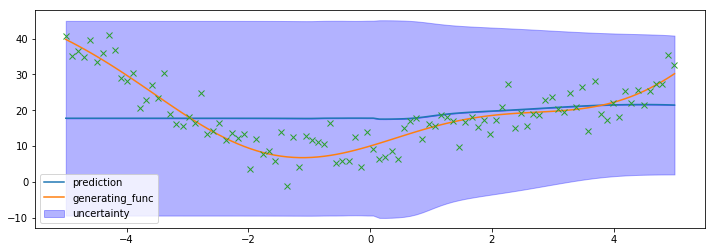

RSME is 8.841699600219727
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 25.009624481201172
COVERAGE/MEAN_VAR is 0.039984606756157566


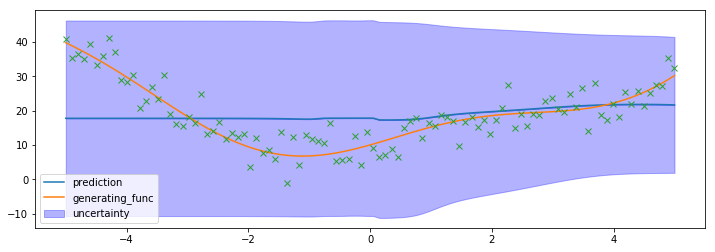

RSME is 8.800257682800293
COVERAGE PROBABILITY is 1.0
MEAN VARIANCE is 25.9722957611084
COVERAGE/MEAN_VAR is 0.0385025647789452


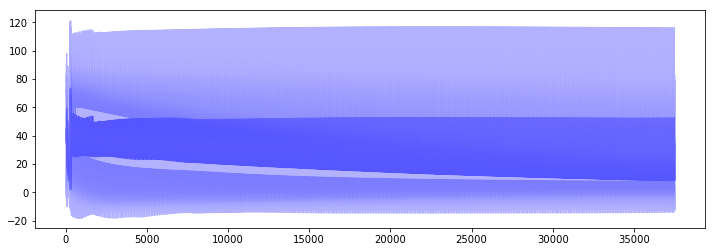

In [30]:
import numpy as np
n_samples = 3
num_epochs = 25#15#10#15
num_eps = 15#25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta = []


#bad_seeds = [2,4,10,13,15,16,9]
#very_bad_seeds = [16,10]
bad_seeds = [1,3]#ignoring the good seeds
very_bad_seeds = []
for i in range(n_samples):
    silent = False
    if i == n_samples - 1:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        if i not in very_bad_seeds:
            params['seed'] = seed + 100+i
        else:
            params['seed'] = seed + 100+i + 42 + i

    gauss_tmp = GaussianLossEstimator(**params)

    errors = train_and_plot(gauss_tmp,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

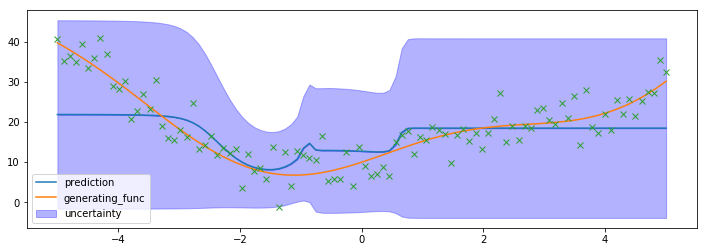

RSME is 6.80657434463501
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 19.754009246826172
COVERAGE/MEAN_VAR is 0.05011640865557764


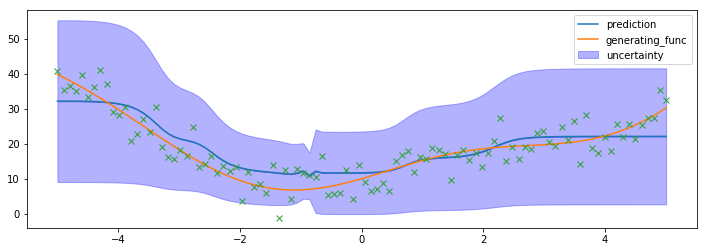

RSME is 4.76524019241333
COVERAGE PROBABILITY is 0.99
MEAN VARIANCE is 16.031923294067383
COVERAGE/MEAN_VAR is 0.06175179246063071


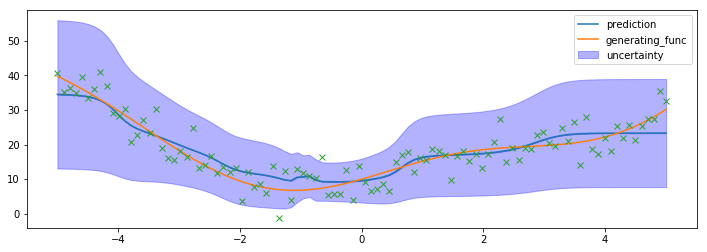

RSME is 4.136051654815674
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 12.51606559753418
COVERAGE/MEAN_VAR is 0.07829936591200609


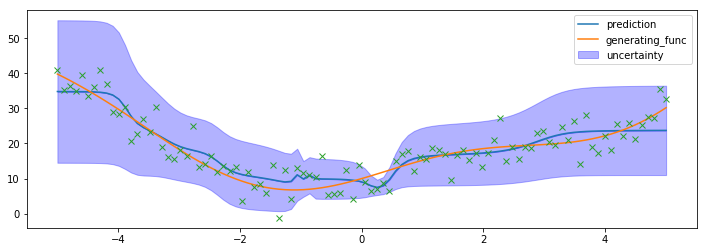

RSME is 3.9843268394470215
COVERAGE PROBABILITY is 0.96
MEAN VARIANCE is 10.647810935974121
COVERAGE/MEAN_VAR is 0.09015937696231961


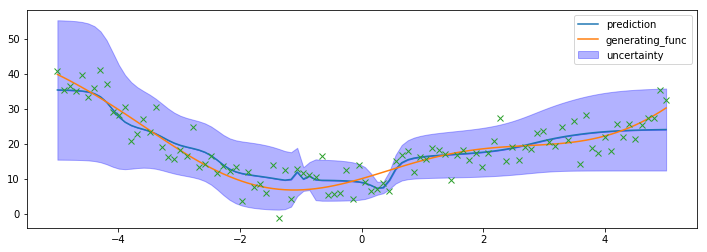

RSME is 3.9408674240112305
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.279212951660156
COVERAGE/MEAN_VAR is 0.10237937257707122


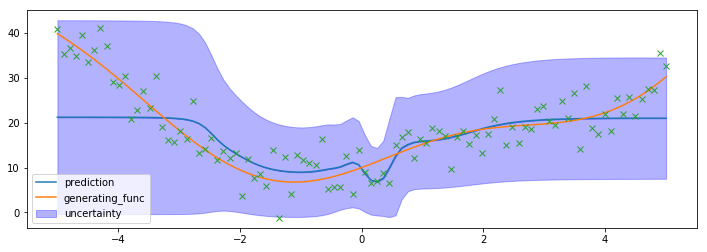

RSME is 6.539119243621826
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 14.244668960571289
COVERAGE/MEAN_VAR is 0.06879766758445587


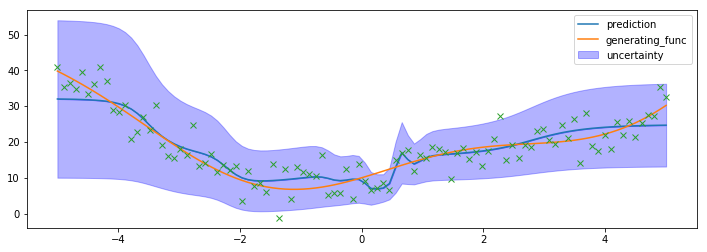

RSME is 4.128705978393555
COVERAGE PROBABILITY is 0.98
MEAN VARIANCE is 11.036067962646484
COVERAGE/MEAN_VAR is 0.08879974310750736


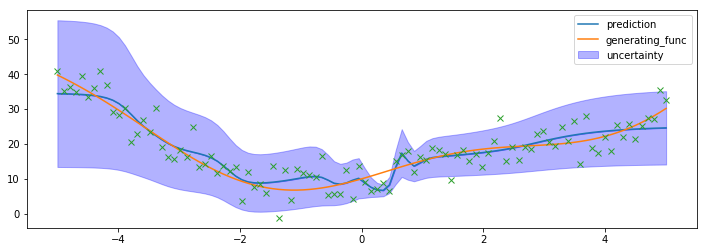

RSME is 3.8643758296966553
COVERAGE PROBABILITY is 0.95
MEAN VARIANCE is 9.836002349853516
COVERAGE/MEAN_VAR is 0.09658395415228302


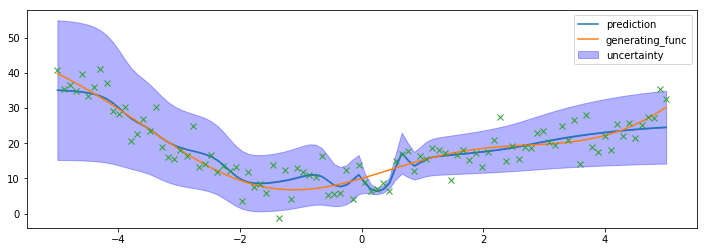

RSME is 3.778149127960205
COVERAGE PROBABILITY is 0.94
MEAN VARIANCE is 9.142037391662598
COVERAGE/MEAN_VAR is 0.10282171902482766


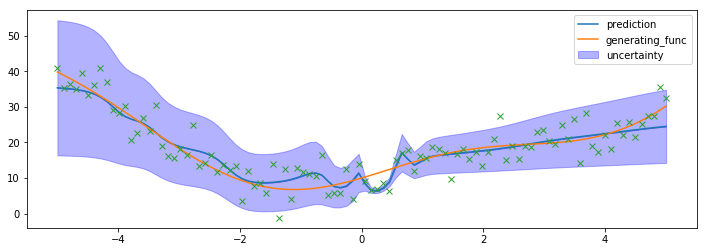

RSME is 3.7704195976257324
COVERAGE PROBABILITY is 0.93
MEAN VARIANCE is 8.779051780700684
COVERAGE/MEAN_VAR is 0.1059339918742083


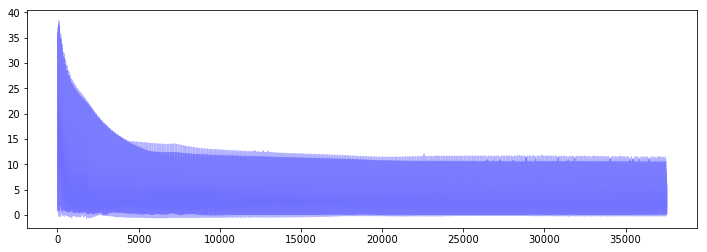

In [31]:
import numpy as np
n_samples = 3
num_epochs = 25#15#10#15
num_eps = 15#25#75
seed = 43#43 is cool 101 1011
params = {'num_neurons':[10,10,10],
          'num_epochs':num_epochs,
          'learning_rate':0.001,
          'seed':seed}


errors_meta = []


#bad_seeds = [2,4,10,13,15,16,9]
#very_bad_seeds = [16,10]
bad_seeds = [1,3]#ignoring the good seeds
very_bad_seeds = []
for i in range(n_samples):
    silent = False
    if i == n_samples - 1:
        silent = True
    if not i in bad_seeds:
        params['seed'] = seed+i
    else:
        if i not in very_bad_seeds:
            params['seed'] = seed + 100+i
        else:
            params['seed'] = seed + 100+i + 42 + i

    gauss_tmp_lr = GaussianLearningRateEstimator(**params)

    errors = train_and_plot(gauss_tmp_lr,X,y,sorted_index,generating_func=generate_sinoid,
                   num_eps=num_eps,silent=silent)
    errors_meta.append(errors)
    
    
    
plot_error_tmp(np.mean(errors_meta,axis=0).flatten(),np.std(errors_meta,axis=0).flatten())

# Old Stuff can probbly be removed only staying for security reasons

In [ ]:
gauss.train(X,y)
gauss_lr.train(X,y)
vanilla.train(X,y)

In [ ]:
gauss_preds = gauss.predict(X)
gauss_var = gauss.predict_var(X)

lr_preds = gauss_lr.predict(X)
lr_var = gauss_lr.predict_var(X)

vanilla_preds = vanilla.predict(X)

In [ ]:
plot_prediction(X,gauss_preds,sorted_index,gauss_var,generating_func=generate_sinoid)
plt.plot(X,y,'x')

In [ ]:
plot_prediction(X,lr_preds,sorted_index,lr_var,generating_func=generate_sinoid)
plt.plot(X,y,'x')

In [ ]:
plot_prediction(X,vanilla_preds,sorted_index,generating_func=generate_sinoid)
plt.plot(X,y,'x')

In [ ]:
evaluate_model(X,y,gauss_preds,var=gauss_var)

In [ ]:
evaluate_model(X,y,lr_preds,var=lr_var)

In [ ]:
evaluate_model(X,y,vanilla_preds)

# Other research
https://arxiv.org/pdf/1406.2541.pdf

https://arxiv.org/pdf/1612.01474.pdf